In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import joblib
from scipy import stats
import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier

from sklearn.metrics import brier_score_loss
from sklearn import metrics
from sklearn.metrics import confusion_matrix

### **Importing & Cleaning the data**

In [2]:
df_orig = pd.read_csv('full_devices.csv', encoding_errors='ignore')

# We will keep an original copy of the
df = df_orig.copy()
print(df.shape)
df.head()

(124494, 12)


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


##### Drop Duplicates (if any)

In [3]:
print(f'len(df) before drop_duplicates:\t {len(df):,}')
print(f'len(df) after drop_duplicates:\t {len(df.drop_duplicates()):,}')
print(f'diff:\t\t\t\t {len(df)-len(df.drop_duplicates()):,}')

df.drop_duplicates(inplace=True)

len(df) before drop_duplicates:	 124,494
len(df) after drop_duplicates:	 124,493
diff:				 1


##### Null Values (if any)

In [4]:
df.isnull().sum()

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

No null values were found.

##### Redundancy

Observing the data, I noticed that two specific columns might be identical:
- `attribute7` and `attribute8`

Let's validate and remove one of them if that is the case:

In [5]:
df_redundant = df.copy()
df_redundant['7_8_identical'] = df_redundant['attribute7'] == df_redundant['attribute8']
df_redundant['7_8_identical'].value_counts()

7_8_identical
True    124493
Name: count, dtype: int64

Indeed, both columns are identical, so let's remove one of them (`attribute8`)

In [6]:
df.drop(columns='attribute8', axis=1, inplace=True)
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3


##### Dtypes

In [7]:
df.dtypes

date          object
device        object
failure        int64
attribute1     int64
attribute2     int64
attribute3     int64
attribute4     int64
attribute5     int64
attribute6     int64
attribute7     int64
attribute9     int64
dtype: object

In [8]:
# We will need to convert 'date' column to datetime format
df['date_dt'] = pd.to_datetime(df['date'])

In [9]:
print(df[['date','date_dt']].dtypes)
df[['date','date_dt']].head(3)

date               object
date_dt    datetime64[ns]
dtype: object


,date,date_dt
0,2015-01-01,2015-01-01
1,2015-01-01,2015-01-01
2,2015-01-01,2015-01-01


##### Describe Data

In [10]:
df.describe().round(2)

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,date_dt
count,124493.00,1.244930e+05,124493.00,124493.00,124493.00,124493.00,124493.00,124493.00,124493.00,124493
mean,0.00,1.223875e+08,159.49,9.94,1.74,14.22,260173.03,0.29,12.45,2015-04-16 05:19:50.900692992
min,0.00,0.000000e+00,0.00,0.00,0.00,1.00,8.00,0.00,0.00,2015-01-01 00:00:00
25%,0.00,6.128346e+07,0.00,0.00,0.00,8.00,221452.00,0.00,0.00,2015-02-09 00:00:00
50%,0.00,1.227971e+08,0.00,0.00,0.00,10.00,249800.00,0.00,0.00,2015-03-27 00:00:00
75%,0.00,1.833091e+08,0.00,0.00,0.00,12.00,310266.00,0.00,0.00,2015-06-17 00:00:00
max,1.00,2.441405e+08,64968.00,24929.00,1666.00,98.00,689161.00,832.00,18701.00,2015-11-02 00:00:00
std,0.03,7.045934e+07,2179.67,185.75,22.91,15.94,99151.39,7.44,191.43,NaN


In [11]:
# FAILURE distribution
print(f'Number of records with failure: {len(df[df['failure']==1])} out of {len(df):,} records \t {round((len(df[df['failure']==1])/len(df))*100,2)}%')
print(f'Number of devices with failure: {len(df[df['failure']==1])} out of {df.device.nunique():,} devices \t {round((len(df[df['failure']==1])/df.device.nunique())*100,2)}%')

Number of records with failure: 106 out of 124,493 records 	 0.09%
Number of devices with failure: 106 out of 1,169 devices 	 9.07%




### **APPROACHING THE PROBLEM**

##### APPROACH #2
As of right now we are preparing the dataset aggregating all data per device.
- Our train data will be a random sample of devices (70% of all devices).
- Our test data will be the remaining (30%) devices.
- Here we would answer the question: Given today's data, what is the probability of the device failing TODAY.
- **ASSUMPTION**: We receive the current date's attributes before it fail and we want to predict if the device would fail at the end of the day.
    - I am not sure we can assume this...

##### APPROACH #2
We could also look at each datapoint, each event independently, and:
- Train the data with part (70%) of the devices that have failed and the scenarios that lead to failure.
- Test the data with the remaining (30%) of the devices that have failed and the probability of failure for each event.
- Here the prediction will be: what is the probability of the device failing in the next event.
    - This would answer our initial question: Should we apply maintenance to that device before it fails?
- **ISSUE**: No aggregation would be done and the number of events with failure is way too small for this approach (106 failures/126,493 records = 0.09% event failure rate)

##### APPROACH #3
We could aggregate the data, but instead of observing the most recent event, we:
- Aggregate the data up to the "second to last" event and have a new response variable: "will fail in next event"
- Our train data will be a random sample of devices (70% of all devices).
- Our test data will be the remaining (30%) devices.
- Here we would answer the question: Given today's data, what is the probability of the device failing TOMORROW.

**I believe that APPROACH #3 is the most adequate.**

Since there is not much information on what each attribute means, we will proceed to aggregate data per device and generate features from that point on.

REMEMBER: We will aggregate the data up to the second to last most recent event for each device.

For this we will need to: 
- remove the most recent record for each device,
- Aggregate the data,
- Add the second to last most recent event's features,
- Add the response variable from the most recent record (which we assume we will not receive when making the predictions).
    - The response variable will be named '`will_fail`'

In [12]:
# df with all most recent record for each device.
df_most_recent = (df[['device', 'date_dt']]
                  .groupby('device')
                  .agg(date_dt=('date_dt','max'))
                  .reset_index()
                  ).merge(df, how='left', on=['device', 'date_dt'])

# df with all records except most recent for each device
#df_except_most_recent = df[df[]]

df_most_recent.failure.value_counts()

failure
0    1068
1     101
Name: count, dtype: int64

Here we have some interesting infromation: there are 5 devices from the 106 total devices with failure that did not have their failures as their respective very last event.

Let's see which devices those are:

In [13]:
df_temp = df.merge(df_most_recent[['device', 'date_dt']].rename(columns={'device':'_device', 'date_dt':'_date_dt'}), 
                   left_on=['device', 'date_dt'], 
                   right_on=['_device', '_date_dt'], 
                   how="outer", 
                   indicator=True
                   ).query('_merge=="left_only"').drop(columns=['_merge', '_device', '_date_dt'], axis=1)

df_temp_clean = df_temp[df_temp['device'].isin(df_temp[df_temp['failure']==1].device.unique())].sort_values(['device', 'date_dt'])

print(df_temp_clean.device.unique().tolist())
print(f'number of rows these devices represent in df: {len(df[df['device'].isin(df_temp_clean.device.unique().tolist())])} out of {len(df):,}')


['S1F0GPFZ', 'S1F136J0', 'W1F0KCP2', 'W1F0M35B', 'W1F11ZG9']
number of rows these devices represent in df: 822 out of 124,493


We could simply eliminate these devices from out dataset, but because we have a small amount of failed cases, 
we will simply remove the records that are not interesting to us, that is, the events after event with failure.

For the records without failure (failure = 0) we will also remove the most recent record for which we are sure did not fail (otherwise we would be assuming that we know that the next event, which we don't have, would not fail).

With all that being said, we will: 
- use the cumsum aggregation and remove all records for which cumsum > 0 (for devices with failure)
- use 
- remove respective most recent record for devices without failure.
- add the response variable 'will_fail' = 1 for devices with failure, and 0 for devices without failure.
- we will then have two df's: one with `'will_fail'=1` and another with `'will_fail'=0`.
- We then proceed to merge these two df's together.

In [14]:
# Use the cumsum aggregation and remove all records for which cumsum > 0 (for devices with failure)

## isolate cases with failure
cases_with_failure = df[df['failure']==1].device.unique().tolist()
df_devices_failure = df[df['device'].isin(cases_with_failure)].copy()
## Create 'cumsum_failure'
df_devices_failure['cumsum_failure'] = df_devices_failure.sort_values(['device','date']).groupby('device')['failure'].cumsum()
## remove all records with 'cumsum_failure' > 0
df_devices_failure = df_devices_failure[df_devices_failure['cumsum_failure']==0].drop(columns='cumsum_failure', axis=1)
## add response variable: 'will_fail'
df_devices_failure['will_fail'] = 1

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# Remove respective most recent record for devices without failure.

## isolate cases without failure
cases_without_failure = df[~df['device'].isin(cases_with_failure)].device.unique().tolist()
df_devices_nofailure = df[df['device'].isin(cases_without_failure)].copy()

## create temporary df with device and most recent date, and remove these rows from df
df_devices_nofailure = df_devices_nofailure.merge((df_devices_nofailure
                                                   .groupby('device')
                                                   .agg(most_recent_date=('date_dt','max'))
                                                   .reset_index()
                                                   .rename(columns={'device':'_device'})
                                                   ),
                                                  how='outer',
                                                  left_on=['device', 'date_dt'], 
                                                  right_on=['_device', 'most_recent_date'], 
                                                  indicator=True).query('_merge=="left_only"').drop(columns=['_merge', '_device', 'most_recent_date'], axis=1)
df_devices_nofailure['will_fail'] = 0

df_devices_nofailure.head()

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

df_clean = pd.concat([df_devices_nofailure, df_devices_failure], )

df_clean.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute9,date_dt,will_fail
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,2015-01-01,0
1,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,7,2015-01-02,0
2,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,7,2015-01-03,0
3,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,7,2015-01-04,0
4,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,7,2015-01-05,0


Now we can proceed to aggregate the data

### **Aggregating the data**

For each attribute we will create it's `mean`, `min`, `max`, `sum` and `nunique` version.

In [15]:
# First aggregate the attributes and date var
df_devices_att = (
    df_clean[['device', 'attribute1', 'attribute2', 'attribute3', 
              'attribute4', 'attribute5', 'attribute6', 'attribute7', #'attribute8'
              'attribute9']]
       .groupby('device')
       .agg(['min','max', 'mean', 'nunique', 'sum', 'std'])
       .reset_index()
       .merge(df_clean[['device', 'date_dt']]
              .groupby('device')
              .agg(['min','max', 'mean', 'nunique'])
              .reset_index(),
              how='left',
              on=['device']
              )
       )

df_devices_att.columns = ['_'.join(col) for col in df_devices_att.columns.values]
df_devices_att.rename(columns={'device_':'device'}, inplace=True)

# Second, we generate the response variable for each device (makes no sense to aggregate 'will_fail' in min, max, mean, nunique)
df_devices_resp = (
    df_clean[['device', 'will_fail']]
    .groupby('device')
    .agg(will_fail=('will_fail','max'))
    )

df_devices = df_devices_resp.merge(df_devices_att, how='left', on='device')
# df_devices.head()
print(df_devices.columns)

Index(['device', 'will_fail', 'attribute1_min', 'attribute1_max',
       'attribute1_mean', 'attribute1_nunique', 'attribute1_sum',
       'attribute1_std', 'attribute2_min', 'attribute2_max', 'attribute2_mean',
       'attribute2_nunique', 'attribute2_sum', 'attribute2_std',
       'attribute3_min', 'attribute3_max', 'attribute3_mean',
       'attribute3_nunique', 'attribute3_sum', 'attribute3_std',
       'attribute4_min', 'attribute4_max', 'attribute4_mean',
       'attribute4_nunique', 'attribute4_sum', 'attribute4_std',
       'attribute5_min', 'attribute5_max', 'attribute5_mean',
       'attribute5_nunique', 'attribute5_sum', 'attribute5_std',
       'attribute6_min', 'attribute6_max', 'attribute6_mean',
       'attribute6_nunique', 'attribute6_sum', 'attribute6_std',
       'attribute7_min', 'attribute7_max', 'attribute7_mean',
       'attribute7_nunique', 'attribute7_sum', 'attribute7_std',
       'attribute9_min', 'attribute9_max', 'attribute9_mean',
       'attribute9_nunique

/var/folders/qh/nnsl9f_d1v97c7xy2jft5k400000gn/T/ipykernel_41158/3293489554.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  .merge(df_clean[['device', 'date_dt']]


##### Most recent row's data

Once we have a trained model, we will receive new data for prediction which will include:
- Historical data on the previous days for a device,
- Data on the curent date, for which we are trying to make the prediction.

With that being said, the current (most recent) date's data is relevant for the prediction.

Let's include this data in our agregated dataframe (df_devices)

In [16]:
df_devices = df_devices.merge(df, how='left', left_on=['device','date_dt_max'], right_on=['device','date_dt'])

In [17]:
df_devices.columns

Index(['device', 'will_fail', 'attribute1_min', 'attribute1_max',
       'attribute1_mean', 'attribute1_nunique', 'attribute1_sum',
       'attribute1_std', 'attribute2_min', 'attribute2_max', 'attribute2_mean',
       'attribute2_nunique', 'attribute2_sum', 'attribute2_std',
       'attribute3_min', 'attribute3_max', 'attribute3_mean',
       'attribute3_nunique', 'attribute3_sum', 'attribute3_std',
       'attribute4_min', 'attribute4_max', 'attribute4_mean',
       'attribute4_nunique', 'attribute4_sum', 'attribute4_std',
       'attribute5_min', 'attribute5_max', 'attribute5_mean',
       'attribute5_nunique', 'attribute5_sum', 'attribute5_std',
       'attribute6_min', 'attribute6_max', 'attribute6_mean',
       'attribute6_nunique', 'attribute6_sum', 'attribute6_std',
       'attribute7_min', 'attribute7_max', 'attribute7_mean',
       'attribute7_nunique', 'attribute7_sum', 'attribute7_std',
       'attribute9_min', 'attribute9_max', 'attribute9_mean',
       'attribute9_nunique

We now have the aggregated data to engineer features

### **Feature engineering**

##### based on 'date_dt'

We will start by calculating the number of days we have data for each device (`date_dt_max-date_dt_min`).

This feature will be called: `num_days`

In [18]:
df_devices['num_days'] = (df_devices['date_dt_max']-df_devices['date_dt_min']).dt.days
print(df_devices[['date_dt_max', 'date_dt_min', 'num_days']].dtypes)
df_devices[['date_dt_max', 'date_dt_min', 'num_days']].head()

date_dt_max    datetime64[ns]
date_dt_min    datetime64[ns]
num_days                int64
dtype: object


,date_dt_max,date_dt_min,num_days
0,2015-01-05,2015-01-01,4
1,2015-05-10,2015-05-06,4
2,2015-01-05,2015-01-01,4
3,2015-02-16,2015-01-01,46
4,2015-01-05,2015-01-01,4


The most recent event we have happens in `date_dt_max`, so we will etract:
- `date_dt_max_day`: what day did the last device's event happen on.
- `date_dt_max_month`: what month did the last device's event happen on.
- `date_dt_max_weekday`: what weekday did the last device's event happen on. (0 = monday, 6 = sunday).

`date_dt_max_year`: we will ignore this feature for it is he same for all observations (2015)

In [19]:
# date_dt_max_day
df_devices['date_dt_max_day'] = df_devices['date_dt_max'].dt.day

# date_dt_max_month
df_devices['date_dt_max_month'] = df_devices['date_dt_max'].dt.month

# date_dt_max_weekday
df_devices['date_dt_max_weekday'] = df_devices['date_dt_max'].dt.weekday

# VALIDATE
print(df_devices[['date_dt_max_day', 'date_dt_max_month', 'date_dt_max_weekday']].describe().round(1))
df_devices[['date_dt_max', 'date_dt_max_day', 'date_dt_max_month', 'date_dt_max_weekday']].head()


       date_dt_max_day  date_dt_max_month  date_dt_max_weekday
count           1168.0             1168.0               1168.0
mean              13.0                4.3                  2.7
std                8.7                3.3                  2.4
min                1.0                1.0                  0.0
25%                5.0                1.0                  0.0
50%               11.0                3.0                  2.0
75%               21.0                8.0                  6.0
max               31.0               10.0                  6.0


,date_dt_max,date_dt_max_day,date_dt_max_month,date_dt_max_weekday
0,2015-01-05,5,1,0
1,2015-05-10,10,5,6
2,2015-01-05,5,1,0
3,2015-02-16,16,2,0
4,2015-01-05,5,1,0


All in all, from the date columns, we now have the features:
- `num_days`: (int64)
- `date_dt_min`: (datetime64[ns])
- `date_dt_max`: (datetime64[ns])
- `date_dt_mean`: (datetime64[ns])
- `date_dt_max_day`: (int32)
- `date_dt_max_month`: (int32)
- `date_dt_max_weekday`: (int32)


##### based on 'device'
I noticed that there are some possible categories we could extract from the `device` column.

In [20]:
# Extract the first three characters of the 'device' column
df_devices['device_0_3'] = df_devices['device'].str[0:3]
print(f'first 3 charcaters: {df_devices['device_0_3'].unique().tolist()}')

# Extract the first three characters of the 'device' column (more granular)
df_devices['device_0_4'] = df_devices['device'].str[0:4]
print(f'first 4 charcaters: {df_devices['device_0_4'].unique().tolist()}')

first 3 charcaters: ['S1F', 'W1F', 'Z1F']
first 4 charcaters: ['S1F0', 'S1F1', 'W1F0', 'W1F1', 'Z1F0', 'Z1F1', 'Z1F2']


Further on, we will apply encoding to these categorica variables. But before, out of curiosity, let's if there is any concentration of device failure in one of these categories:

In [21]:
# For first three characters ('device_0_3')
df_devices[['device_0_3','will_fail']].groupby('device_0_3').agg(num_devices=('device_0_3','count'),
                                                                 will_fail_num=('will_fail','sum'),
                                                                 will_fail_pct=('will_fail','mean')
                                                                 )

,num_devices,will_fail_num,will_fail_pct
device_0_3,,,
S1F,530,42,0.079245
W1F,419,42,0.100239
Z1F,219,22,0.100457


In [22]:
# For first four characters ('device_0_4')
df_devices[['device_0_4','will_fail']].groupby('device_0_4').agg(num_devices=('device_0_4','count'),
                                                                 will_fail_num=('will_fail','sum'),
                                                                 will_fail_pct=('will_fail','mean')
                                                                 ).sort_values('will_fail_pct', ascending=False)

,num_devices,will_fail_num,will_fail_pct
device_0_4,,,
Z1F1,67,9,0.134328
W1F1,137,15,0.109489
W1F0,282,27,0.095745
S1F0,391,36,0.092072
Z1F0,149,13,0.087248
S1F1,139,6,0.043165
Z1F2,3,0,0.000000


There is a more evident difference for the 'device_0_4' feature so we will proceed to use that one as our categorical variable.

We have now created (possibly) all relevant features with the data that we were given.

Before we continue we will create a function that applies all of that preprocessing as well as the encoding of the categorical variabels.

### **Preprocessing and Encoding**

##### Preprocessing Train/Test data (preprocessin_train)

In [23]:
def preprocessing_train(df):
    # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
    # Drop duplicates
    print('1) Dropping duplicates...')
    df.drop_duplicates(inplace=True)
    print('Done!')
    print('-'*50)

    # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
    # Convert 'date' column from object to datetime
    print('2) Converting \'date\' columns to datetime format...')
    df['date_dt'] = pd.to_datetime(df['date'])
    print('Done!')
    print('-'*50)

    # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
    # Approach #3 data prep.
    print("Approach #3 data prep. started... ")

    # Use the cumsum aggregation and remove all records for which cumsum > 0 (for devices with failure)
    ## isolate cases with failure
    cases_with_failure = df[df['failure']==1].device.unique().tolist()
    df_devices_failure = df[df['device'].isin(cases_with_failure)].copy()
    ## Create 'cumsum_failure'
    df_devices_failure['cumsum_failure'] = df_devices_failure.sort_values(['device','date']).groupby('device')['failure'].cumsum()
    ## remove all records with 'cumsum_failure' > 0
    df_devices_failure = df_devices_failure[df_devices_failure['cumsum_failure']==0].drop(columns='cumsum_failure', axis=1)
    ## add response variable: 'will_fail'
    df_devices_failure['will_fail'] = 1

    # - - - - - - - - - - - - - - - -
    # Remove respective most recent record for devices without failure.
    ## isolate cases without failure
    cases_without_failure = df[~df['device'].isin(cases_with_failure)].device.unique().tolist()
    df_devices_nofailure = df[df['device'].isin(cases_without_failure)].copy()

    ## create temporary df with device and most recent date, and remove these rows from df
    df_devices_nofailure = df_devices_nofailure.merge((df_devices_nofailure
                                                    .groupby('device')
                                                    .agg(most_recent_date=('date_dt','max'))
                                                    .reset_index()
                                                    .rename(columns={'device':'_device'})
                                                    ),
                                                    how='outer',
                                                    left_on=['device', 'date_dt'], 
                                                    right_on=['_device', 'most_recent_date'], 
                                                    indicator=True).query('_merge=="left_only"').drop(columns=['_merge', '_device', 'most_recent_date'], axis=1)
    df_devices_nofailure['will_fail'] = 0
    
    # - - - - - - - - - - - - - - - -
    df_clean = pd.concat([df_devices_nofailure, df_devices_failure])

    print('Done!')
    print('-'*50)

    # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
    # Aggregating the data
    print('3) Aggergating the data (groupby \'device\')...')

    print('min/max/mean/nunique/sum...')
    # First aggregate the attributes and date var
    # df_devices_att = (
    #     df[['device', 'attribute1', 'attribute2', 'attribute3', 
    #             'attribute4', 'attribute5', 'attribute6', 'attribute7', #'attribute8'
    #             'attribute9', 'date_dt']]
    #     .groupby('device')
    #     .agg(['min','max', 'mean', 'nunique']) # , 'sum'])
    #     ).reset_index()
    
    # First aggregate the attributes and date var
    df_devices_att = (
        df[['device', 'attribute1', 'attribute2', 'attribute3', 
                'attribute4', 'attribute5', 'attribute6', 'attribute7', #'attribute8'
                'attribute9']]
        .groupby('device')
        .agg(['min','max', 'mean', 'nunique', 'sum', 'std'])
        .reset_index()
        .merge(df[['device', 'date_dt']]
                .groupby('device')
                .agg(['min','max', 'mean', 'nunique'])
                .reset_index(),
                how='left',
                on=['device']
                )
        )

    df_devices_att.columns = ['_'.join(col) for col in df_devices_att.columns.values]
    df_devices_att.rename(columns={'device_':'device'}, inplace=True)
    
    print("response variable 'will_fail'...")
    # Second, we generate the response variable for each device (makes no sense to aggregate 'will_fail' in min, max, mean, nunique)
    df_devices_resp = (
        df_clean[['device', 'will_fail']]
        .groupby('device')
        .agg(will_fail=('will_fail','max'))
        )
    df_devices = df_devices_resp.merge(df_devices_att, how='left', on='device')

    print("adding most recent record's atttributes (originally second to last)...")
    # Now we add the most recent row's data (which originally was the second to last most recent row)
    df_devices = df_devices.merge(df, how='left', left_on=['device','date_dt_max'], right_on=['device','date_dt'])
    
    print('Done!')
    print('-'*50)

    # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
    # Feature Engineering
    print('4) Feature Engineering phase:')
    
    # 'num_days'
    print("creating 'num_days'...")
    df_devices['num_days'] = (df_devices['date_dt_max']-df_devices['date_dt_min']).dt.days
    print("'num_days' created!")

    # 'date_dt_max_day'
    print("creating 'date_dt_max_day'...")
    df_devices['date_dt_max_day'] = df_devices['date_dt_max'].dt.day
    print("'date_dt_max_day' created!")

    # 'date_dt_max_month'
    print("creating 'date_dt_max_month'...")
    df_devices['date_dt_max_month'] = df_devices['date_dt_max'].dt.month
    print("'date_dt_max_month' created!")

    # 'date_dt_max_weekday'
    print("creating 'date_dt_max_weekday'...")
    df_devices['date_dt_max_weekday'] = df_devices['date_dt_max'].dt.weekday
    print("'date_dt_max_weekday' created!")
    
    # 'device_0_4'
    print("creating 'device_0_4'...")
    df_devices['device_0_4'] = df_devices['device'].str[0:4]
    print("'device_0_4' created!")

    print('Feature Engineering phase done!')
    print('-'*50)
    
    # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
    # OneHotEncoder phase
    print('5) Encoding the categorical features:')

    categ_vars = ['device_0_4']
    onehot_enc = ce.OneHotEncoder(use_cat_names = True, handle_unknown = 'ignore').fit(df_devices[categ_vars])
    onehot_vars = onehot_enc.transform(df_devices[categ_vars])

    df_devices = df_devices.drop(categ_vars, axis=1)
    df_devices = pd.concat([df_devices, onehot_vars], axis = 1)

    train_encoder_name = 'train_encoder'
    filehandler = open(train_encoder_name + '.obj',"wb")
    pickle.dump(onehot_enc,filehandler)
    filehandler.close()

    print('Done!')
    print('-'*50)
    # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 

    df_devices = df_devices[[
        'device', 
        # 'date', 'failure', 'date_dt', # (Has been ignored or aggregated already)
        # 'date_dt_min', 'date_dt_max', 'date_dt_mean', # (only numerical vars are accepted)
        'num_days', 
        'date_dt_max_day', 'date_dt_max_month', 'date_dt_max_weekday',
        # 'device_0_4', # Has been encoded
        'device_0_4_S1F0', 'device_0_4_S1F1', 'device_0_4_W1F0', 
        'device_0_4_W1F1', 'device_0_4_Z1F0', 'device_0_4_Z1F1', 
        # 'device_0_4_Z1F2' # We can exclude one of columns after encoder (I chose the least frequent value)
        'attribute1', 'attribute1_min', 'attribute1_max', 'attribute1_mean', 'attribute1_nunique', 'attribute1_sum', 'attribute1_std', 
        'attribute2', 'attribute2_min', 'attribute2_max', 'attribute2_mean', 'attribute2_nunique', 'attribute2_sum', 'attribute2_std', 
        'attribute3', 'attribute3_min', 'attribute3_max', 'attribute3_mean', 'attribute3_nunique', 'attribute3_sum', 'attribute3_std', 
        'attribute4', 'attribute4_min', 'attribute4_max', 'attribute4_mean', 'attribute4_nunique', 'attribute4_sum', 'attribute4_std', 
        'attribute5', 'attribute5_min', 'attribute5_max', 'attribute5_mean', 'attribute5_nunique', 'attribute5_sum', 'attribute5_std', 
        'attribute6', 'attribute6_min', 'attribute6_max', 'attribute6_mean', 'attribute6_nunique', 'attribute6_sum', 'attribute6_std', 
        'attribute7', 'attribute7_min', 'attribute7_max', 'attribute7_mean', 'attribute7_nunique', 'attribute7_sum', 'attribute7_std', 
        #'attribute8', 'attribute8_min', 'attribute8_max', 'attribute8_mean', 'attribute8_nunique', 'attribute8_sum', 'attribute8_std', # (redundant feature)
        'attribute9', 'attribute9_min', 'attribute9_max', 'attribute9_mean', 'attribute9_nunique', 'attribute9_sum', 'attribute9_std',
        'will_fail']]
    
    # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
    print('PREPROCESSING IS DONE!')
    return df_devices

##### Preprocessing Production data (preprocessin_prod)

In [24]:
def preprocessin_prod(df):
    # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
    # Drop duplicates
    print('1) Dropping duplicates...')
    df.drop_duplicates(inplace=True)
    print('Done!')
    print('-'*50)

    # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
    # Convert 'date' column from object to datetime
    print('2) Converting \'date\' columns to datetime format...')
    df['date_dt'] = pd.to_datetime(df['date'])
    print('Done!')
    print('-'*50)

    # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
    # Aggregating the data
    print('3) Aggergating the data (groupby \'device\')...')

    print('min/max/mean/nunique/sum...')
    # First aggregate the attributes and date var
    # df_devices_att = (
    #     df[['device', 'attribute1', 'attribute2', 'attribute3', 
    #             'attribute4', 'attribute5', 'attribute6', 'attribute7', #'attribute8'
    #             'attribute9', 'date_dt']]
    #     .groupby('device')
    #     .agg(['min','max', 'mean', 'nunique']) # , 'sum'])
    #     ).reset_index()
    
    # First aggregate the attributes and date var
    df_devices_att = (
        df[['device', 'attribute1', 'attribute2', 'attribute3', 
                'attribute4', 'attribute5', 'attribute6', 'attribute7', #'attribute8'
                'attribute9']]
        .groupby('device')
        .agg(['min','max', 'mean', 'nunique', 'sum', 'std'])
        .reset_index()
        .merge(df[['device', 'date_dt']]
                .groupby('device')
                .agg(['min','max', 'mean', 'nunique'])
                .reset_index(),
                how='left',
                on=['device']
                )
        )


    df_devices_att.columns = ['_'.join(col) for col in df_devices_att.columns.values]
    df_devices_att.rename(columns={'device_':'device'}, inplace=True)
    
    print('Done!')
    print('-'*50)

    # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
    # Feature Engineering
    print('4) Feature Engineering phase:')
    
    # 'num_days'
    print("creating 'num_days'...")
    df_devices['num_days'] = (df_devices['date_dt_max']-df_devices['date_dt_min']).dt.days
    print("'num_days' created!")

    # 'date_dt_max_day'
    print("creating 'date_dt_max_day'...")
    df_devices['date_dt_max_day'] = df_devices['date_dt_max'].dt.day
    print("'date_dt_max_day' created!")

    # 'date_dt_max_month'
    print("creating 'date_dt_max_month'...")
    df_devices['date_dt_max_month'] = df_devices['date_dt_max'].dt.month
    print("'date_dt_max_month' created!")

    # 'date_dt_max_weekday'
    print("creating 'date_dt_max_weekday'...")
    df_devices['date_dt_max_weekday'] = df_devices['date_dt_max'].dt.weekday
    print("'date_dt_max_weekday' created!")
    
    # 'device_0_4'
    print("creating 'device_0_4'...")
    df_devices['device_0_4'] = df_devices['device'].str[0:4]
    print("'device_0_4' created!")

    print('Feature Engineering phase done!')
    print('-'*50)

    # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
    # OneHotEncoder phase
    print('5) Encoding the categorical features:')

    categ_vars = ['device_0_4']
    onehot_enc = ce.OneHotEncoder(use_cat_names = True, handle_unknown = 'ignore').fit(df_devices[categ_vars])
    onehot_vars = onehot_enc.transform(df_devices[categ_vars])

    df_devices = df_devices.drop(categ_vars, axis=1)
    df_devices = pd.concat([df_devices, onehot_vars], axis = 1)

    train_encoder_name = 'train_encoder'
    filehandler = open(train_encoder_name + '.obj',"wb")
    pickle.dump(onehot_enc,filehandler)
    filehandler.close()

    print('Done!')
    print('-'*50)
    # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 

    df_devices = df_devices[[
        'device', 
        # 'date', 'failure', 'date_dt', # (Has been ignored or aggregated already)
        # 'date_dt_min', 'date_dt_max', 'date_dt_mean', # (only numerical vars are accepted)
        'num_days',
        'date_dt_max_day', 'date_dt_max_month', 'date_dt_max_weekday',
        # 'device_0_4', # Has been encoded
        'device_0_4_S1F0', 'device_0_4_S1F1', 'device_0_4_W1F0', 
        'device_0_4_W1F1', 'device_0_4_Z1F0', 'device_0_4_Z1F1', 
        # 'device_0_4_Z1F2' # We can exclude one of columns after encoder (I chose the least frequent value)
        'attribute1', 'attribute1_min', 'attribute1_max', 'attribute1_mean', 'attribute1_nunique', 'attribute1_sum', 'attribute1_std', 
        'attribute2', 'attribute2_min', 'attribute2_max', 'attribute2_mean', 'attribute2_nunique', 'attribute2_sum', 'attribute2_std', 
        'attribute3', 'attribute3_min', 'attribute3_max', 'attribute3_mean', 'attribute3_nunique', 'attribute3_sum', 'attribute3_std', 
        'attribute4', 'attribute4_min', 'attribute4_max', 'attribute4_mean', 'attribute4_nunique', 'attribute4_sum', 'attribute4_std', 
        'attribute5', 'attribute5_min', 'attribute5_max', 'attribute5_mean', 'attribute5_nunique', 'attribute5_sum', 'attribute5_std', 
        'attribute6', 'attribute6_min', 'attribute6_max', 'attribute6_mean', 'attribute6_nunique', 'attribute6_sum', 'attribute6_std', 
        'attribute7', 'attribute7_min', 'attribute7_max', 'attribute7_mean', 'attribute7_nunique', 'attribute7_sum', 'attribute7_std', 
        #'attribute8', 'attribute8_min', 'attribute8_max', 'attribute8_mean', 'attribute8_nunique', 'attribute8_sum', 'attribute8_std', # (redundant feature)
        'attribute9', 'attribute9_min', 'attribute9_max', 'attribute9_mean', 'attribute9_nunique', 'attribute9_sum', 'attribute9_std',
        #'will_fail' # (non-existent for prod. data)
        ]]

    # -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
    print('PREPROCESSING IS DONE!')
    return df_devices

    

##### SAMPLING

In [25]:

def rand_sample_devices(df, train_split=0.7, seed=1234):
    
    X = df_devices_new.drop('will_fail', axis=1)
    y = df_devices_new[['will_fail']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, random_state=seed)
    
    # Let's store the devices for X_train and X_test before we drop them from those dataframes
    
    X_train_devices = X_train[['device']]
    X_train.drop('device', axis=1, inplace=True)
    # Convert all float columns to int
    X_train = X_train.astype(int)

    X_test_devices = X_test[['device']]
    X_test.drop('device', axis=1, inplace=True)
    X_test = X_test.astype(int)

    return X_train, X_test, y_train, y_test, X_train_devices, X_test_devices

### **EXECUTING PHASE**

##### PREPROCESSING & TRAIN/TEST SPLIT

In [26]:
df_devices_new = preprocessing_train(df)
df_devices_new.head()

1) Dropping duplicates...
Done!
--------------------------------------------------
2) Converting 'date' columns to datetime format...
Done!
--------------------------------------------------
Approach #3 data prep. started... 
Done!
--------------------------------------------------
3) Aggergating the data (groupby 'device')...
min/max/mean/nunique/sum...
response variable 'will_fail'...
adding most recent record's atttributes (originally second to last)...
Done!
--------------------------------------------------
4) Feature Engineering phase:
creating 'num_days'...
'num_days' created!
creating 'date_dt_max_day'...
'date_dt_max_day' created!
creating 'date_dt_max_month'...
'date_dt_max_month' created!
creating 'date_dt_max_weekday'...
'date_dt_max_weekday' created!
creating 'device_0_4'...
'device_0_4' created!
Feature Engineering phase done!
--------------------------------------------------
5) Encoding the categorical features:
Done!
--------------------------------------------------
P

/var/folders/qh/nnsl9f_d1v97c7xy2jft5k400000gn/T/ipykernel_41158/2916237494.py:78: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  .merge(df[['device', 'date_dt']]


,device,num_days,date_dt_max_day,date_dt_max_month,date_dt_max_weekday,device_0_4_S1F0,device_0_4_S1F1,device_0_4_W1F0,device_0_4_W1F1,device_0_4_Z1F0,...,attribute7_sum,attribute7_std,attribute9,attribute9_min,attribute9_max,attribute9_mean,attribute9_nunique,attribute9_sum,attribute9_std,will_fail
0,S1F01085,5,6,1,1,1,0,0,0,0,...,0,0.0,7,7,7,7.0,1,42,0.0,0
1,S1F013BB,5,11,5,0,1,0,0,0,0,...,0,0.0,0,0,0,0.0,1,0,0.0,0
2,S1F0166B,5,6,1,1,1,0,0,0,0,...,0,0.0,0,0,0,0.0,1,0,0.0,0
3,S1F01E6Y,47,17,2,1,1,0,0,0,0,...,0,0.0,0,0,0,0.0,1,0,0.0,0
4,S1F01JE0,5,6,1,1,1,0,0,0,0,...,0,0.0,0,0,0,0.0,1,0,0.0,0


In [27]:
X_train, X_test, y_train, y_test, X_train_devices, X_test_devices = rand_sample_devices(df_devices_new, train_split=0.7, seed=1234)

### **MODELING PHASE**

##### CORRELATION MATRIX & SCATTER MATRIX

In [28]:
def correlation_ratio(categorical_feature, numeric_feature):
    cats, freqs = np.unique(categorical_feature, return_counts=True)
    numeric_mean = np.mean(numeric_feature)
    sig_y_bar = 0
    for i in range(len(cats)):
        category_mean = np.mean(numeric_feature[categorical_feature == cats[i]])
        sig_y_bar += np.square(category_mean - numeric_mean) * freqs[i]
    sig_y = np.sum(np.square(numeric_feature - numeric_mean))
    statistic = np.sqrt(sig_y_bar / sig_y)
    return statistic

def plot_correlation_matrix(df):
    for each in ['pearson', 'spearman', 'kendall', correlation_ratio]:
        corr = df.corr(method=each)
        ax = sns.heatmap(
            corr, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True
        )
        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=45,
            horizontalalignment='right'
        )
        try:
            ax.set_title(each.upper())
        except:
            ax.set_title(each.__name__.upper())
        plt.show()        

In [29]:
#plot_correlation_matrix(X_train)

In [30]:
#X_train.columns
cols_for_correl = ['num_days', 'date_dt_max_day', 'date_dt_max_month', 'date_dt_max_weekday', 
'device_0_4_S1F0', 'device_0_4_S1F1', 'device_0_4_W1F0', 'device_0_4_W1F1', 'device_0_4_Z1F0', 'device_0_4_Z1F1', 
'attribute1', 'attribute2', 'attribute3', 'attribute4',
'attribute5', 'attribute6', 'attribute7', 'attribute9']

### **TRAIN MODEL**

In [31]:
def train_model(X, y, hyper_tuning=0, calibrate_prob=0, seed=1234, model_filename='trained_model', save_model=1, model_selected='RandomForestClassifier'):
    
    if model_selected == 'RandomForestClassifier':
        if hyper_tuning == 1:
            params = calibrate_hyperparameters(X, y, model_filename, seed=seed)
            #print(params)
            #model = XGBClassifier()
            model = RandomForestClassifier(**params)
            
        else:
            model = RandomForestClassifier()
        
        if calibrate_prob == 1:
            model = CalibratedClassifierCV(model, method='isotonic', cv = 3)
    
    elif model_selected == 'LigisticRegression':
        model = LogisticRegression()

    elif model_selected == 'XGBClassifier':
        if hyper_tuning == 1:
            params = calibrate_hyperparameters_xgb(X, y, model_filename, seed=seed)
            #print(params)
            model = XGBClassifier(**params)
            
        else:
            model = XGBClassifier()
        
        if calibrate_prob == 1:
            model = CalibratedClassifierCV(model, method='isotonic', cv = 3)
    
    else:
        raise ValueError('model_selected is invalid...')

    model.fit(X, y.values.ravel())
    
    if save_model == 1:
        pickle.dump(model, open(model_filename, 'wb'))
    
    return model, X


def calibrate_hyperparameters(X, y, model_filename, seed=1234):
    """
    Inputs:
        - X: Dataframe de variáveis explicativas.
        - y: Dataframe com a variável-resposta.
        - model_filename: nome do arquivo a ser salvo com o melhor modelo treinado, se for o caso.
    Outputs:
        - best: dicionário contendo os hiperparâmetros do melhor modelo.    
    """

    print('Calibrating model hyperparameters...')
    print(X.shape, y.shape)

    rf = RandomForestClassifier(random_state = seed)
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 8)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 50, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier(random_state = seed)
    # Random search of parameters
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                                   n_iter = 10, cv = 3, verbose = 3, random_state = 12345, n_jobs = 6)
    # Fit the random search model

    with joblib.parallel_backend('threading', n_jobs = 6):
        rf_random.fit(X, y.values.ravel())

    best = rf_random.best_params_
    
    print('Calibration done!')
    
    return best


def calibrate_hyperparameters_xgb(X, y, model_filename, seed=1234):
    """
    Inputs:
        - X: Dataframe de variáveis explicativas.
        - y: Dataframe com a variável-resposta.
        - model_filename: nome do arquivo a ser salvo com o melhor modelo treinado, se for o caso.
    Outputs:
        - best: dicionário contendo os hiperparâmetros do melhor modelo.    
    """

    print('Calibrating model hyperparameters...')
    print(X.shape, y.shape)

    xgb = XGBClassifier(random_state = seed)
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 8)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 50, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    xgb = XGBClassifier(random_state = seed)
    # Random search of parameters
    xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid,
                                   n_iter = 10, cv = 3, verbose = 3, random_state = 12345, n_jobs = 6)
    # Fit the random search model

    with joblib.parallel_backend('threading', n_jobs = 6):
        xgb_random.fit(X, y.values.ravel())

    best = xgb_random.best_params_
    
    print('Calibration done!')
    
    return best

### **APPLY MODEL**

In [35]:
def apply_model(X, model_filename='trained_model', response_var_name='will_fail'):
    """
    Função para aplicar o modelo treinado em uma nova base/dataframe.
    
    Inputs:
        - X: Dataframe já pré-processado para o qual o modelo treinado
        deve ser aplicado.
        - variaveis_id: lista com variáveis de identificação, que não devem ser usadas no modelo
        - model_filename: nome do arquivo contendo o modelo a ser utilizado.
        
    Outputs:
        - Dataframe contendo a probabilidade estimada, "preds", para cada observação
        do conjunto de previsão.
        - X: Dataframe de variáveis explicativas do modelo.
    
    """
    
    print('Applying the trained model on X (X_test)...')
    model = pickle.load(open(model_filename, 'rb'))
    
    print('Size of X (X_test)...')
    print(X.shape)
    
    preds = model.predict_proba(X)
    #preds = model.predict_proba(X)[::,1]
    
    XX = X.copy()
    #XX = pd.concat([col_exc, X], axis = 1)
    XX['preds'] = preds[:,1]
    
    preds_ = pd.DataFrame(preds[:,1], columns = ['prob_est_' + response_var_name])
    
    return preds_, XX

In [36]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# EXECUTE TRAIN MODEL
# Available dfs: X_train, X_test, y_train, y_test, X_train_devices, X_test_devices

#model, X = train_model(X_train, y_train, hyper_tuning=1, calibrate_prob=1, seed=1234)
#model, X = train_model(X_train, y_train, hyper_tuning=1, calibrate_prob=1, seed=1234, model_selected='XGBClassifier')
model, X = train_model(X_train, y_train, hyper_tuning=0, calibrate_prob=0, seed=1234, model_selected='XGBClassifier')

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# APPLY MODEL TO X_TEST
# Available dfs: X_train, X_test, y_train, y_test, X_train_devices, X_test_devices

preds, X_test_preds = apply_model(X_test)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# PREPARE DATA FOR EVALUATION
response_var_name = 'will_fail'

X_preds_vs_real = pd.concat([X_test_devices, X_test_preds[['preds']]], axis=1)
X_preds_vs_real = pd.concat([X_preds_vs_real, y_test], axis=1)
X_preds_vs_real['y_preds'] = (X_preds_vs_real['preds']>=0.5).astype(int)

Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


In [42]:
# EVALUATION

# ROC Curve
def roc_plot(X, y):
    fpr, tpr, _ = metrics.roc_curve(y, X['preds'])
    auc = metrics.roc_auc_score(y, X['preds'])
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    return auc

# Probability Curve
def prob_plot(X, y, response_var_name):
    quantiles = 10
    X['decile'] = pd.qcut(X['preds'].copy(), quantiles, duplicates = 'drop')
    X[response_var_name] = y
    real_prob = X.groupby('decile')[response_var_name].mean()
    est_prob = X.groupby('decile')['preds'].mean()
    max_eixo = max(real_prob.max(), est_prob.max())
    plt.scatter(est_prob, real_prob)
    plt.plot([0, max_eixo + 0.001], [0, max_eixo + 0.001], color = 'black', linewidth = 2)
    plt.title(f'PREDs vs REAL ({response_var_name})')
    plt.xlabel(f'Predicted Probability ({response_var_name})')
    plt.ylabel('Real Probability({response_var_name})')
    print(X.shape)
    X = X.drop(columns = [response_var_name, 'decile'])
    brier = brier_score_loss(y, X['preds'])
    plt.show()
    return brier

# Confusion Matrix
def confusion_matrix_heatmap(df, y_pred_col='y_preds', y_col='will_fail'):
    #Get confusion matrix
    y_pred = X_preds_vs_real[[y_pred_col]].copy()
    y = X_preds_vs_real[[y_col]].copy()
    cf_matrix = confusion_matrix(y, y_pred)

    #Plot confusion matrix
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.show()
    return cf_matrix

# Results Summary
def results_summary(df=X_preds_vs_real, real_y_name='will_fail', pred_y_name='y_preds'):
    def investment_calc_func(a,b):
        result = 1 if a==1 and b==0 else 0.5*b
        return result
    X_evaulation = X_preds_vs_real[['device',real_y_name,pred_y_name]]
    X_evaulation['ideal_investment'] = X_evaulation[real_y_name]*0.5
    X_evaulation['model_investment'] = X_evaulation.apply(lambda x: investment_calc_func(x[real_y_name], x[pred_y_name]), axis=1)
    #X_evaulation.head(50)

    print(f'Worst investment: ${X_evaulation[real_y_name].sum()}')
    print(f'Ideal investment: ${X_evaulation.ideal_investment.sum()}')
    print(f'Model investment: ${X_evaulation.model_investment.sum()}')
    print('-'*100)
    print(f'Total Opportunity:\t ${X_evaulation[real_y_name].sum()-X_evaulation.ideal_investment.sum()}\t\t ({round((X_evaulation[real_y_name].sum()-X_evaulation.ideal_investment.sum())/X_evaulation[real_y_name].sum()*100,2)}% of worst investment/no maintainance)')
    print(f'Total savings:\t\t ${X_evaulation[real_y_name].sum()-X_evaulation.model_investment.sum()}\t\t ({round((X_evaulation[real_y_name].sum()-X_evaulation.model_investment.sum())/(X_evaulation[real_y_name].sum()-X_evaulation.ideal_investment.sum())*100,2)}% of total opportunity)')
    print(f'Missed savings:\t\t ${X_evaulation.model_investment.sum()-X_evaulation.ideal_investment.sum()}\t\t ({round((X_evaulation.model_investment.sum()-X_evaulation.ideal_investment.sum())/(X_evaulation[real_y_name].sum()-X_evaulation.ideal_investment.sum())*100,2)}% of total opportunity)')

    total_monetary_savings = X_evaulation[real_y_name].sum()-X_evaulation.model_investment.sum()
    total_pct_savings = (X_evaulation[real_y_name].sum()-X_evaulation.model_investment.sum())/(X_evaulation[real_y_name].sum()-X_evaulation.ideal_investment.sum())
    total_opportunity = X_evaulation[real_y_name].sum()-X_evaulation.ideal_investment.sum()
    return total_opportunity, total_monetary_savings, total_pct_savings


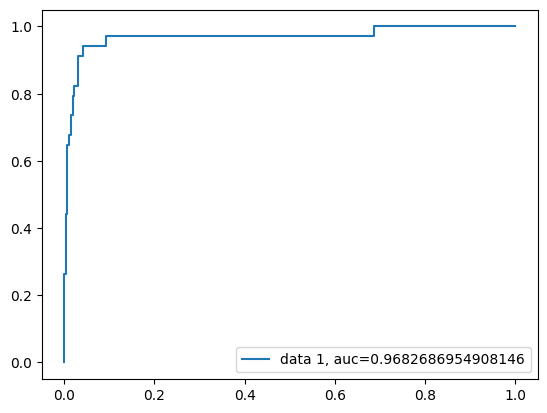

(351, 3)


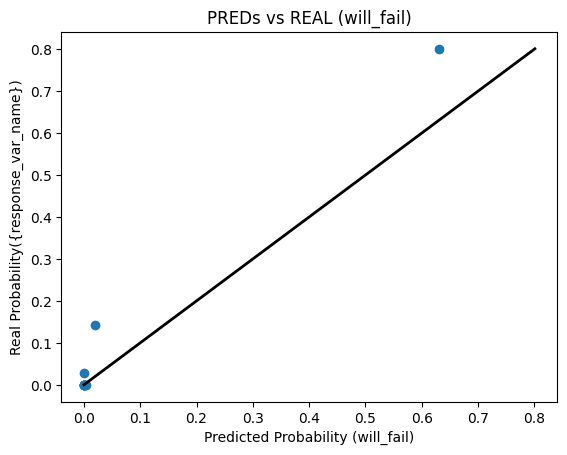

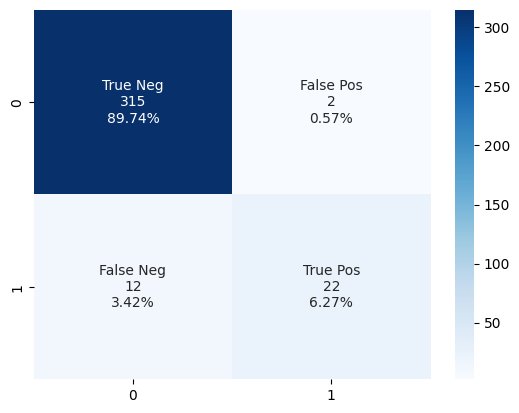

Worst investment: $34
Ideal investment: $17.0
Model investment: $24.0
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $17.0		 (50.0% of worst investment/no maintainance)
Total savings:		 $10.0		 (58.82% of total opportunity)
Missed savings:		 $7.0		 (41.18% of total opportunity)


(17.0, 10.0, 0.5882352941176471)

In [38]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Plot ROC, PROB_PLOT (pred vs. real), and CONFUSION_MATRIX
#X = X_preds_vs_real[['y_preds']].rename(columns={'y_preds':'preds'})
X = X_preds_vs_real[['preds']].copy()
y = X_preds_vs_real[['will_fail']].copy()
response_var_name = 'will_fail'

auc_ = roc_plot(X, y)
brier_ = prob_plot(X, y, response_var_name)
cf_matrix = confusion_matrix_heatmap(df=X_preds_vs_real, y_pred_col='y_preds', y_col='will_fail')

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
#PRINT INVESTMENT RESULTS
results_summary(df=X_preds_vs_real, real_y_name='will_fail', pred_y_name='y_preds')

### **BEST RESULTS** (Base Models - XGBClassifier & RandomForest)

- BASE MODELS -- BASE MODELS -- BASE MODELS -- BASE MODELS -- BASE MODELS -
================================================== RANDOMFORESTCLASSIFIER ==================================================
-------------------------------------------------- RANDOMFORESTCLASSIFIER --> seed = 0 --------------------------------------------------
Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


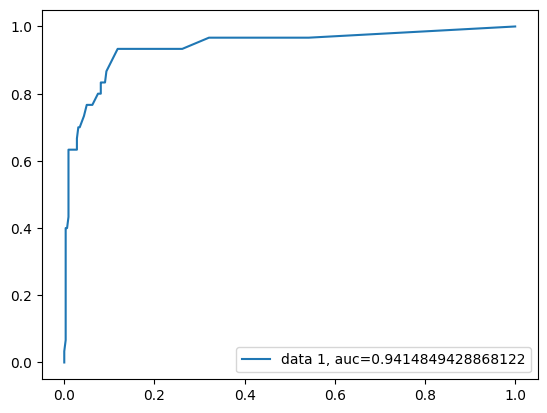

(351, 3)


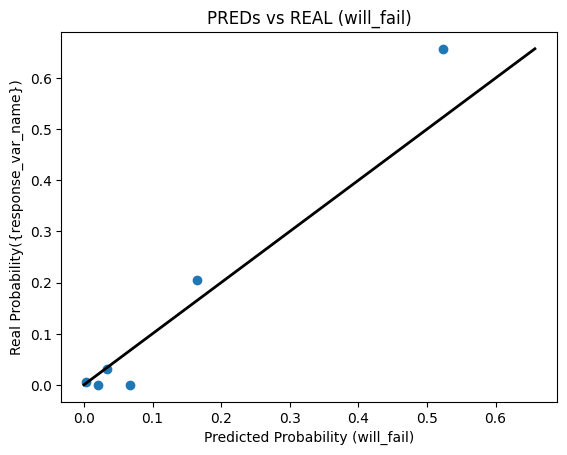

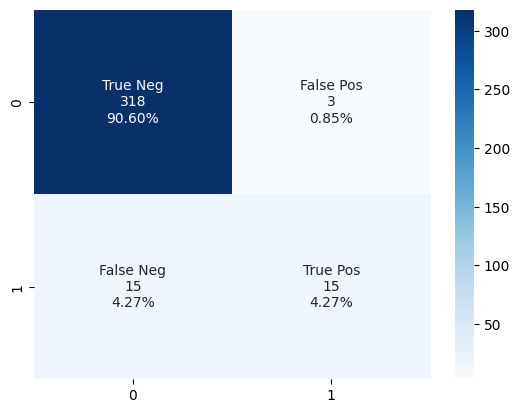

---------- RANDOMFORESTCLASSIFIER --> seed = 0 RESULTS ----------
Worst investment: $30
Ideal investment: $15.0
Model investment: $24.0
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $15.0		 (50.0% of worst investment/no maintainance)
Total savings:		 $6.0		 (40.0% of total opportunity)
Missed savings:		 $9.0		 (60.0% of total opportunity)




-------------------------------------------------- RANDOMFORESTCLASSIFIER --> seed = 50 --------------------------------------------------
Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


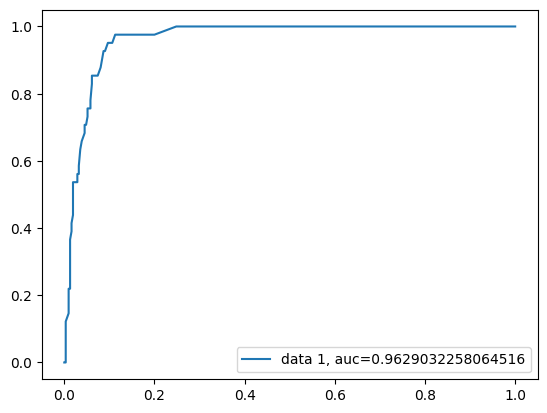

(351, 3)


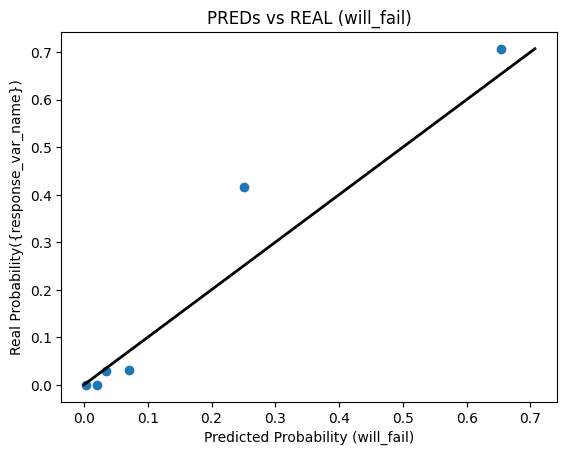

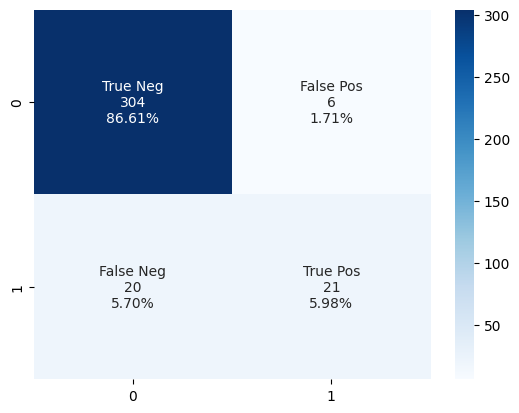

---------- RANDOMFORESTCLASSIFIER --> seed = 50 RESULTS ----------
Worst investment: $41
Ideal investment: $20.5
Model investment: $33.5
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $20.5		 (50.0% of worst investment/no maintainance)
Total savings:		 $7.5		 (36.59% of total opportunity)
Missed savings:		 $13.0		 (63.41% of total opportunity)




-------------------------------------------------- RANDOMFORESTCLASSIFIER --> seed = 100 --------------------------------------------------
Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


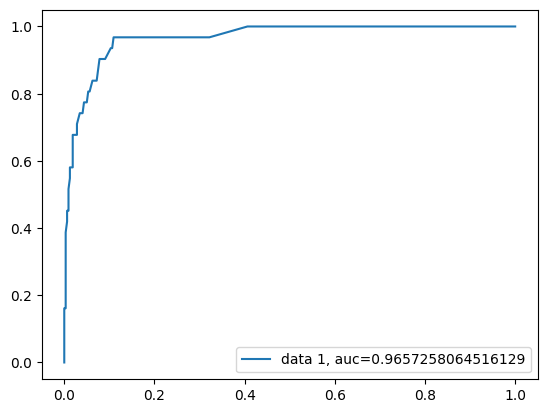

(351, 3)


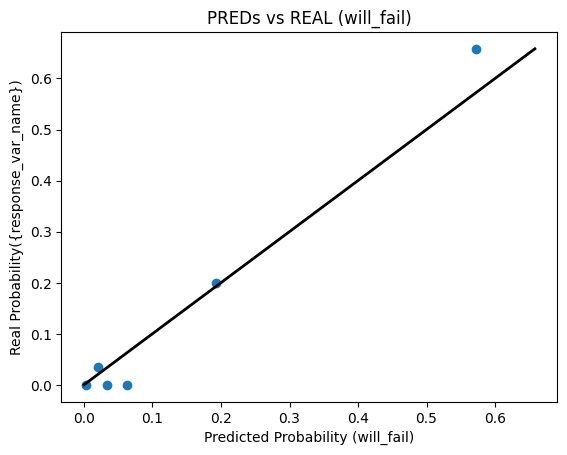

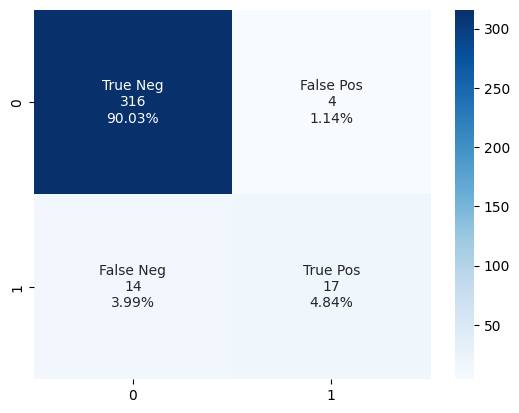

---------- RANDOMFORESTCLASSIFIER --> seed = 100 RESULTS ----------
Worst investment: $31
Ideal investment: $15.5
Model investment: $24.5
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $15.5		 (50.0% of worst investment/no maintainance)
Total savings:		 $6.5		 (41.94% of total opportunity)
Missed savings:		 $9.0		 (58.06% of total opportunity)




-------------------------------------------------- RANDOMFORESTCLASSIFIER --> seed = 150 --------------------------------------------------
Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


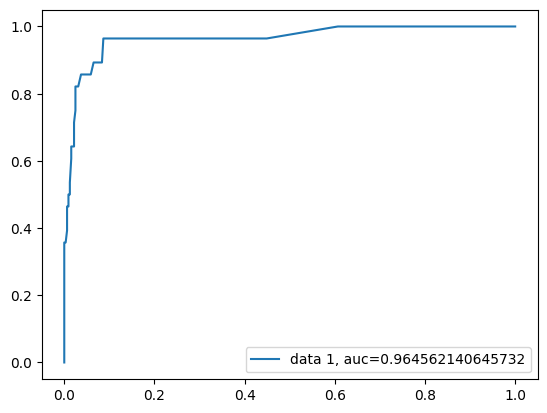

(351, 3)


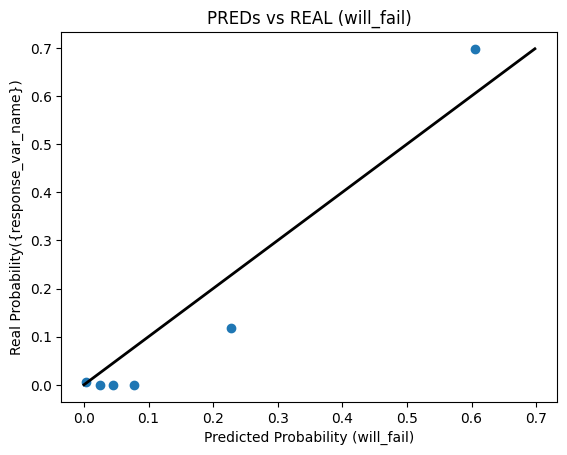

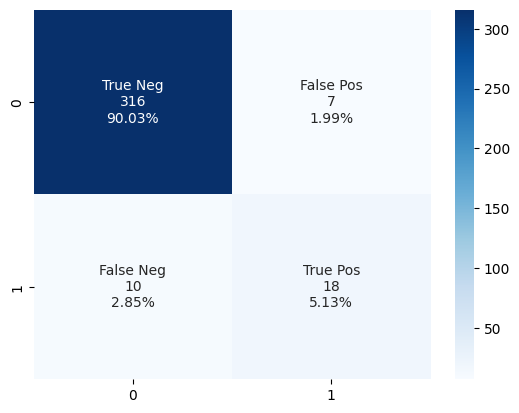

---------- RANDOMFORESTCLASSIFIER --> seed = 150 RESULTS ----------
Worst investment: $28
Ideal investment: $14.0
Model investment: $22.5
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $14.0		 (50.0% of worst investment/no maintainance)
Total savings:		 $5.5		 (39.29% of total opportunity)
Missed savings:		 $8.5		 (60.71% of total opportunity)




-------------------------------------------------- RANDOMFORESTCLASSIFIER --> seed = 1234 --------------------------------------------------
Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


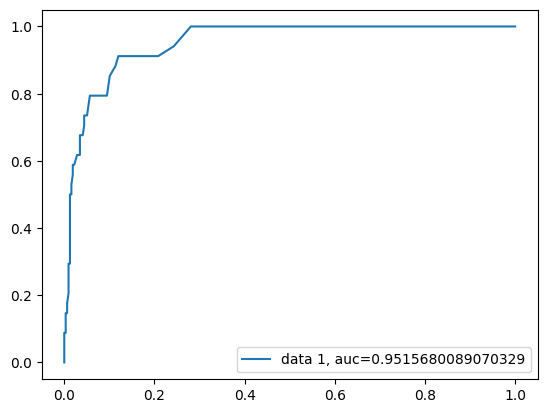

(351, 3)


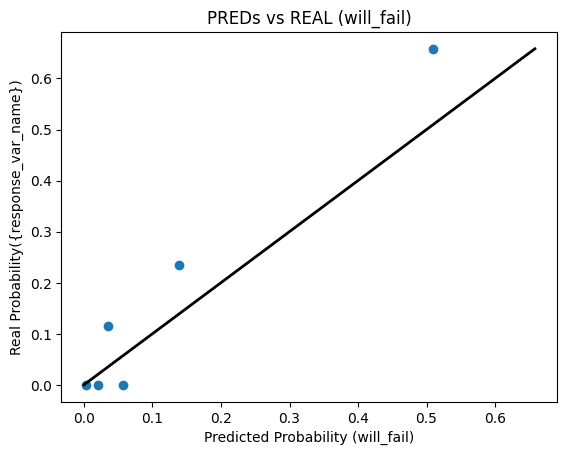

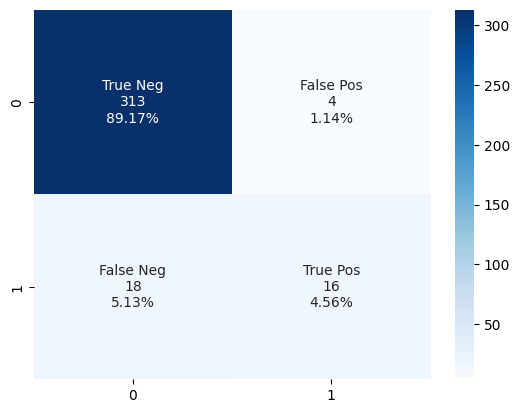

---------- RANDOMFORESTCLASSIFIER --> seed = 1234 RESULTS ----------
Worst investment: $34
Ideal investment: $17.0
Model investment: $28.0
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $17.0		 (50.0% of worst investment/no maintainance)
Total savings:		 $6.0		 (35.29% of total opportunity)
Missed savings:		 $11.0		 (64.71% of total opportunity)




================================================== XGBCLASSIFIER ==================================================
-------------------------------------------------- XGBCLASSIFIER --> seed = 0 --------------------------------------------------
Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


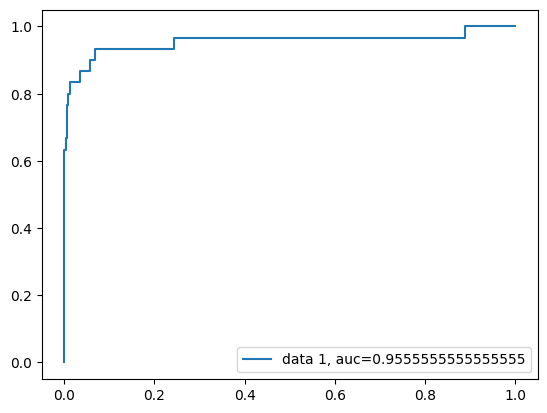

(351, 3)


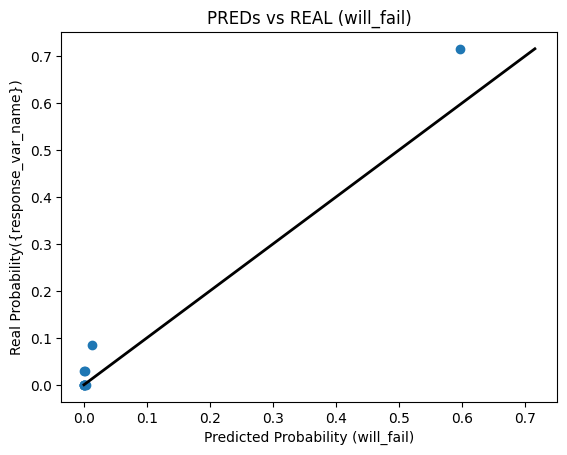

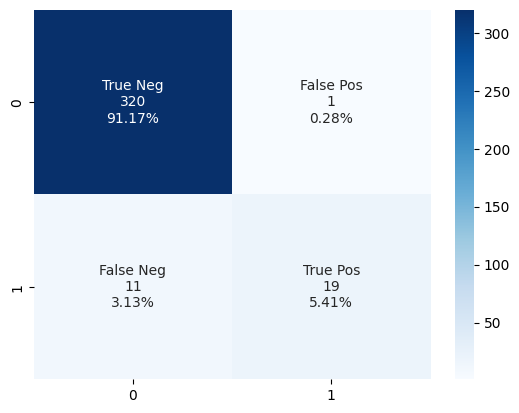

---------- XGBCLASSIFIER --> seed = 0 RESULTS ----------
Worst investment: $30
Ideal investment: $15.0
Model investment: $21.0
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $15.0		 (50.0% of worst investment/no maintainance)
Total savings:		 $9.0		 (60.0% of total opportunity)
Missed savings:		 $6.0		 (40.0% of total opportunity)




-------------------------------------------------- XGBCLASSIFIER --> seed = 50 --------------------------------------------------
Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


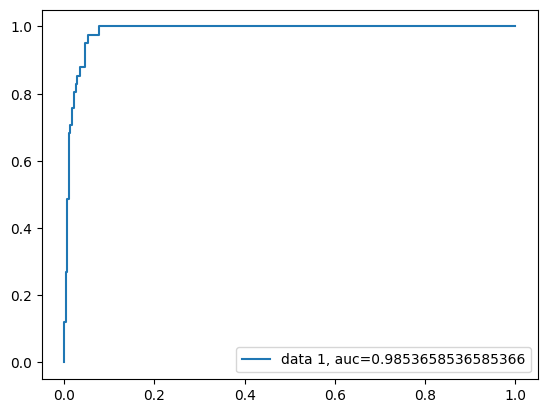

(351, 3)


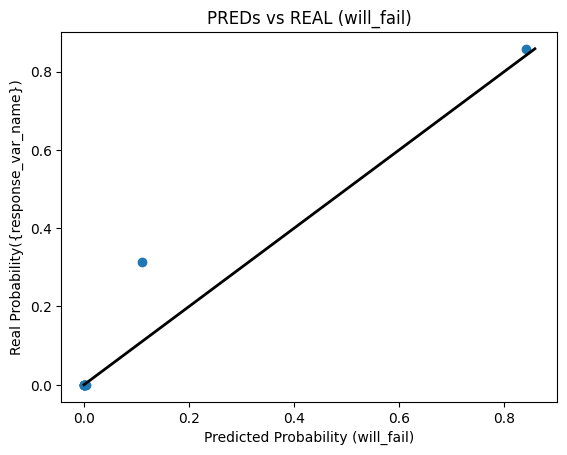

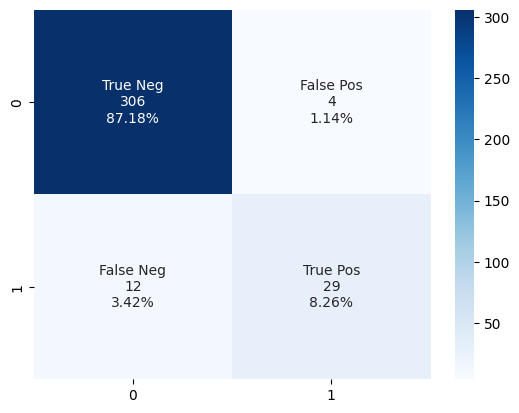

---------- XGBCLASSIFIER --> seed = 50 RESULTS ----------
Worst investment: $41
Ideal investment: $20.5
Model investment: $28.5
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $20.5		 (50.0% of worst investment/no maintainance)
Total savings:		 $12.5		 (60.98% of total opportunity)
Missed savings:		 $8.0		 (39.02% of total opportunity)




-------------------------------------------------- XGBCLASSIFIER --> seed = 100 --------------------------------------------------
Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


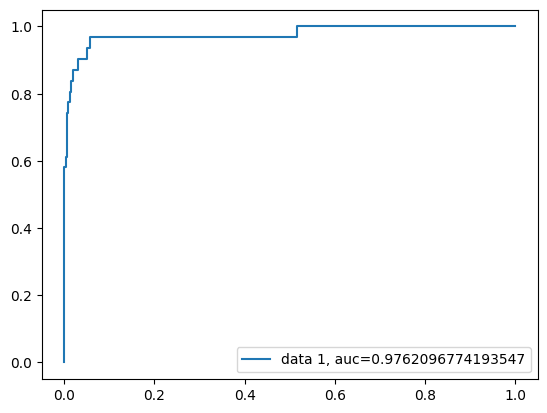

(351, 3)


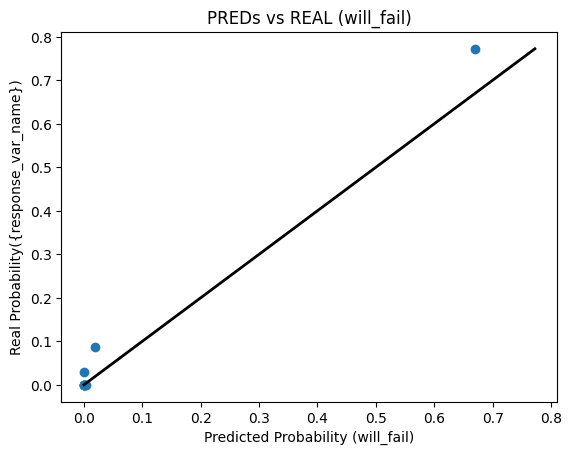

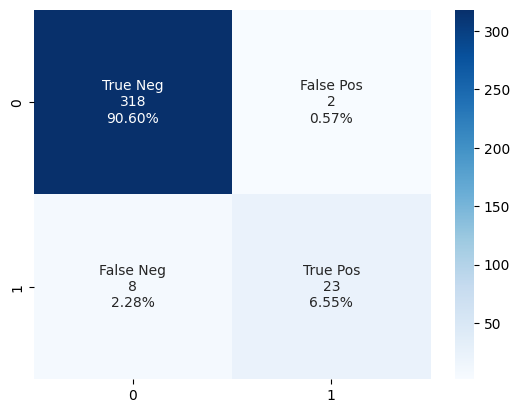

---------- XGBCLASSIFIER --> seed = 100 RESULTS ----------
Worst investment: $31
Ideal investment: $15.5
Model investment: $20.5
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $15.5		 (50.0% of worst investment/no maintainance)
Total savings:		 $10.5		 (67.74% of total opportunity)
Missed savings:		 $5.0		 (32.26% of total opportunity)




-------------------------------------------------- XGBCLASSIFIER --> seed = 150 --------------------------------------------------
Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


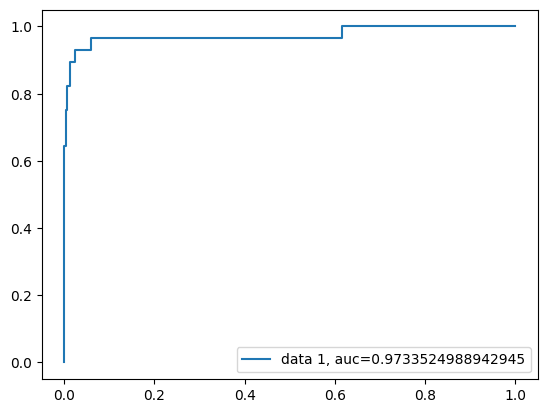

(351, 3)


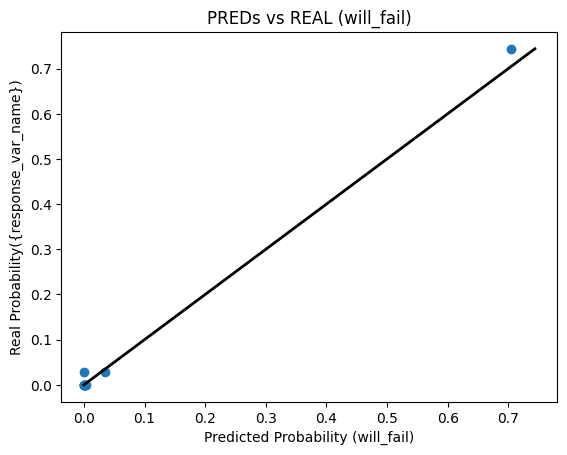

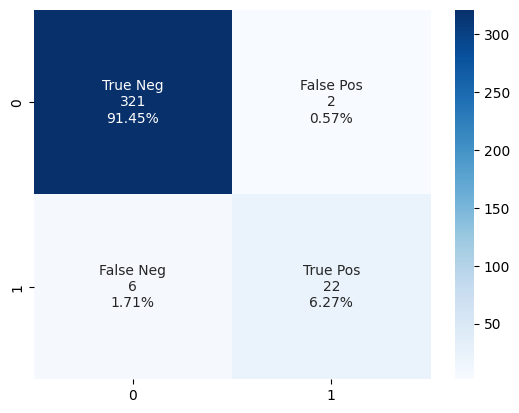

---------- XGBCLASSIFIER --> seed = 150 RESULTS ----------
Worst investment: $28
Ideal investment: $14.0
Model investment: $18.0
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $14.0		 (50.0% of worst investment/no maintainance)
Total savings:		 $10.0		 (71.43% of total opportunity)
Missed savings:		 $4.0		 (28.57% of total opportunity)




-------------------------------------------------- XGBCLASSIFIER --> seed = 1234 --------------------------------------------------
Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


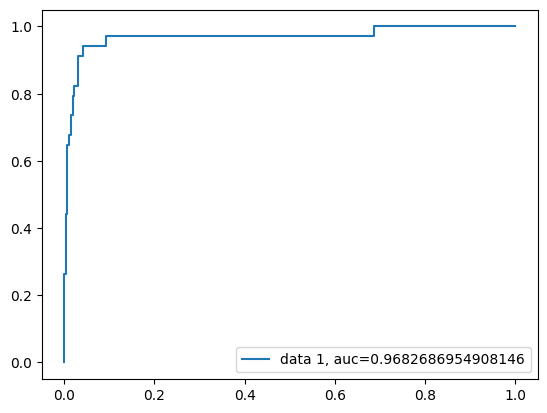

(351, 3)


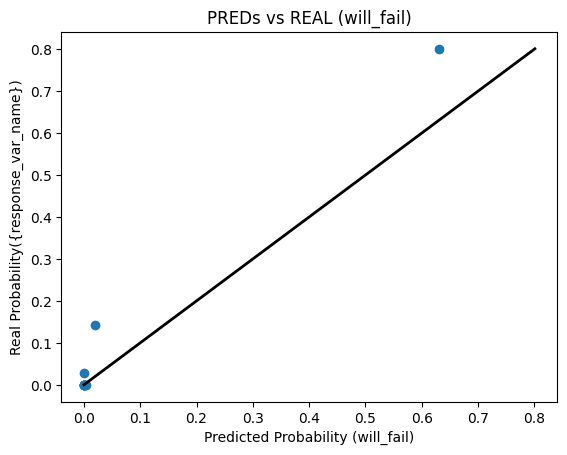

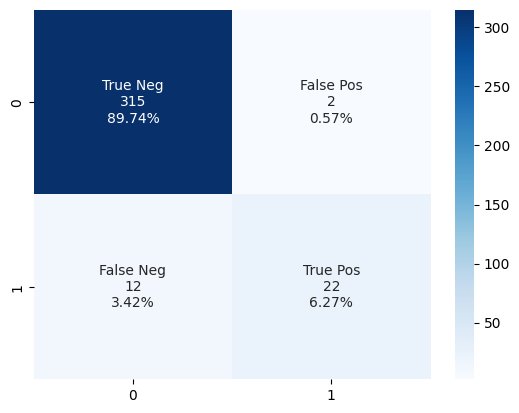

---------- XGBCLASSIFIER --> seed = 1234 RESULTS ----------
Worst investment: $34
Ideal investment: $17.0
Model investment: $24.0
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $17.0		 (50.0% of worst investment/no maintainance)
Total savings:		 $10.0		 (58.82% of total opportunity)
Missed savings:		 $7.0		 (41.18% of total opportunity)






In [39]:
models = ['RandomForestClassifier', 'XGBClassifier']
seeds = list(range(0,200,50))+[1234]

print('- BASE MODELS -'*5)
for selected_model in models:
    print('='*50,selected_model.upper(),'='*50)
    
    for seed in seeds:
        X_train, X_test, y_train, y_test, X_train_devices, X_test_devices = rand_sample_devices(df_devices_new, train_split=0.7, seed=seed)
        
        print('-'*50,selected_model.upper(),'--> seed =',seed,'-'*50)
        
        #Train model
        model, X = train_model(X_train, y_train, hyper_tuning=0, calibrate_prob=0, seed=seed, model_selected=selected_model)
        
        #Apply model
        preds, X_test_preds = apply_model(X_test)
        
        #Join Results
        response_var_name = 'will_fail'
        X_preds_vs_real = pd.concat([X_test_devices, X_test_preds[['preds']]], axis=1)
        X_preds_vs_real = pd.concat([X_preds_vs_real, y_test], axis=1)
        X_preds_vs_real['y_preds'] = (X_preds_vs_real['preds']>=0.5).astype(int)

        # Plot ROC Curve and Prob_plot
        X = X_preds_vs_real[['preds']].copy()
        y = X_preds_vs_real[['will_fail']].copy()
        auc_ = roc_plot(X, y)
        brier_ = prob_plot(X, y, response_var_name)
        cf_matrix = confusion_matrix_heatmap(df=X_preds_vs_real, y_pred_col='y_preds', y_col='will_fail')

        print('-'*10,selected_model.upper(),'--> seed =',seed,'RESULTS','-'*10)
        results_summary(df=X_preds_vs_real, real_y_name='will_fail', pred_y_name='y_preds')
        print('\n')
        print('='*140)
        print('\n')

### **BEST RESULTS** (HyperParameter Tuning and Probability Calibration - XGBClassifier & RandomForest)

- BASE MODELS -- BASE MODELS -- BASE MODELS -- BASE MODELS -- BASE MODELS -
================================================== RANDOMFORESTCLASSIFIER ==================================================
-------------------------------------------------- RANDOMFORESTCLASSIFIER --> seed = 0 --------------------------------------------------
Calibrating model hyperparameters...
(817, 66) (817, 1)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 3/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=False, max_depth=22, max_features=auto, min_samples_leaf=1, min_

/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/

Calibration done!
Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


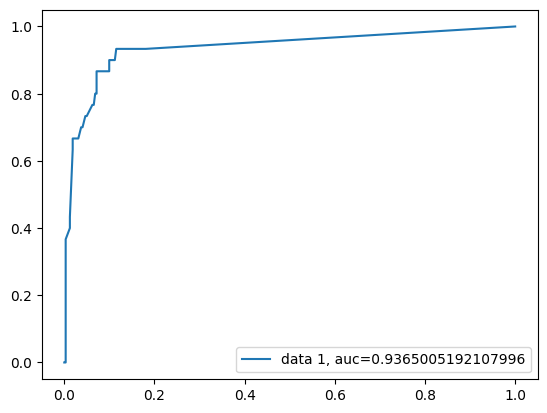

(351, 3)


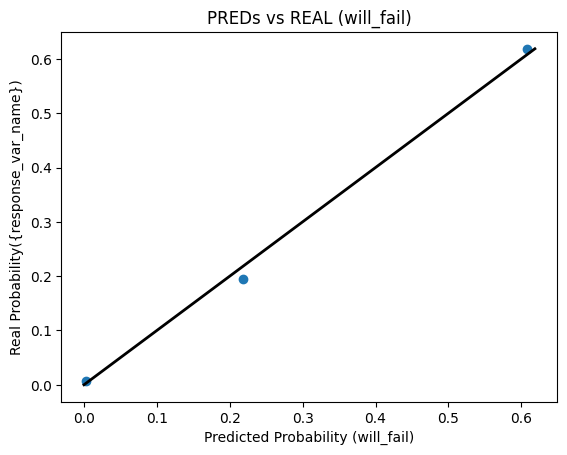

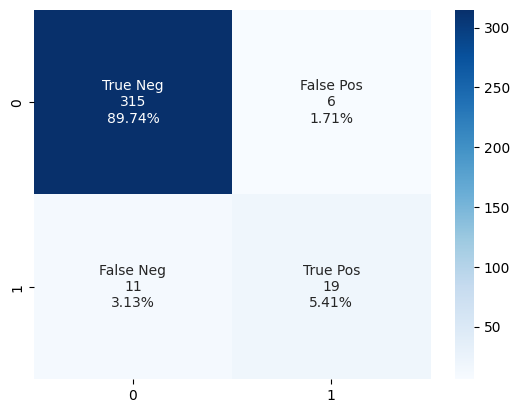

---------- RANDOMFORESTCLASSIFIER --> seed = 0 RESULTS ----------
Worst investment: $30
Ideal investment: $15.0
Model investment: $23.5
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $15.0		 (50.0% of worst investment/no maintainance)
Total savings:		 $6.5		 (43.33% of total opportunity)
Missed savings:		 $8.5		 (56.67% of total opportunity)




-------------------------------------------------- RANDOMFORESTCLASSIFIER --> seed = 50 --------------------------------------------------
Calibrating model hyperparameters...
(817, 66) (817, 1)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=nan total time=   0.0s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=nan total time=   0.0s
[CV 2/3] END boo

/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/

Calibration done!
Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


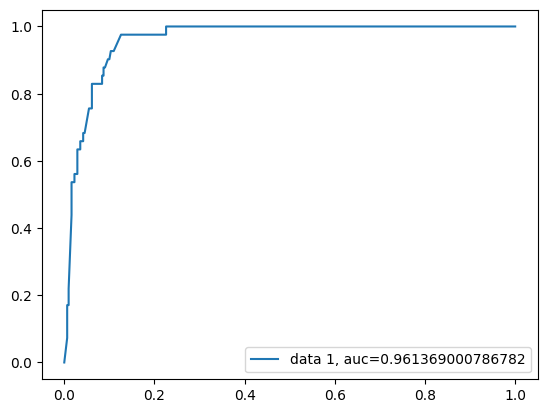

(351, 3)


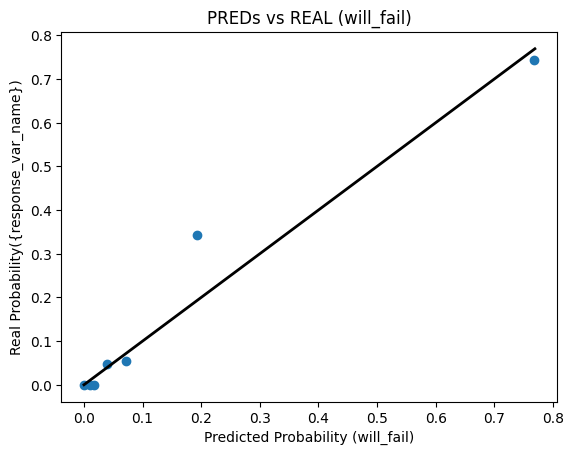

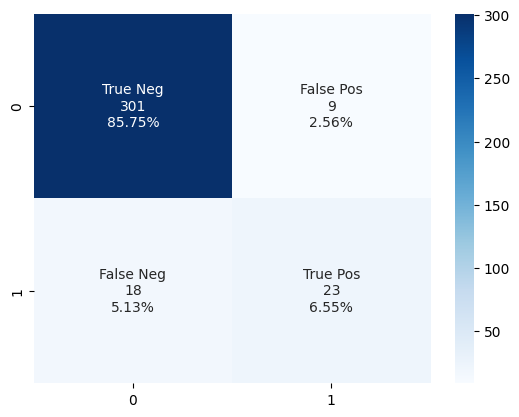

---------- RANDOMFORESTCLASSIFIER --> seed = 50 RESULTS ----------
Worst investment: $41
Ideal investment: $20.5
Model investment: $34.0
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $20.5		 (50.0% of worst investment/no maintainance)
Total savings:		 $7.0		 (34.15% of total opportunity)
Missed savings:		 $13.5		 (65.85% of total opportunity)




-------------------------------------------------- RANDOMFORESTCLASSIFIER --> seed = 100 --------------------------------------------------
Calibrating model hyperparameters...
(817, 66) (817, 1)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=nan total time=   0.0s
[CV 1/3] END boot

/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/

Calibration done!
Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


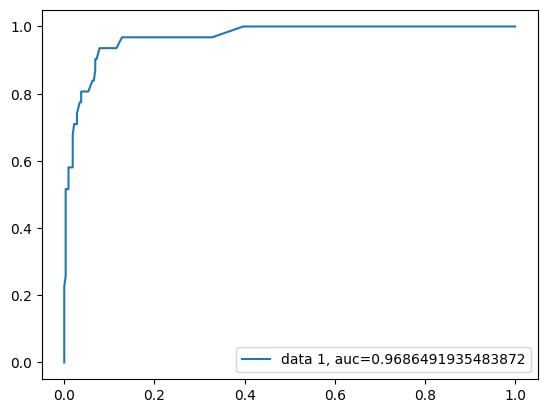

(351, 3)


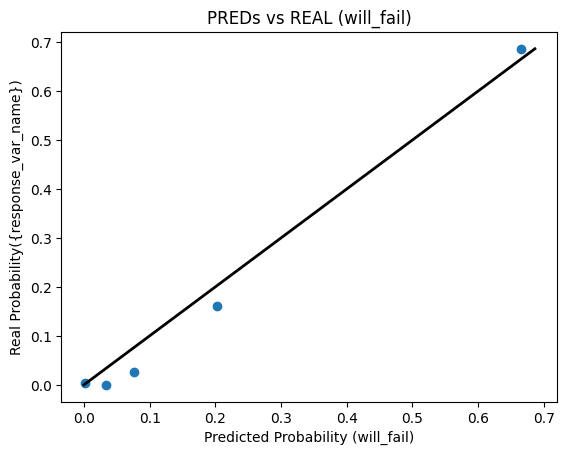

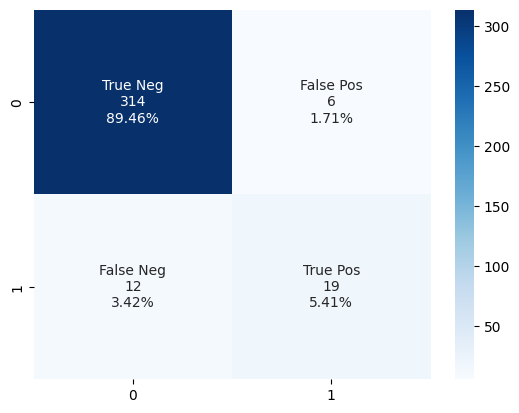

---------- RANDOMFORESTCLASSIFIER --> seed = 100 RESULTS ----------
Worst investment: $31
Ideal investment: $15.5
Model investment: $24.5
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $15.5		 (50.0% of worst investment/no maintainance)
Total savings:		 $6.5		 (41.94% of total opportunity)
Missed savings:		 $9.0		 (58.06% of total opportunity)




-------------------------------------------------- RANDOMFORESTCLASSIFIER --> seed = 150 --------------------------------------------------
Calibrating model hyperparameters...
(817, 66) (817, 1)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 2/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=nan total time=   0.0s
[CV 3/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=nan total time=   0.0s
[CV 1/3] END boot

/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/

Calibration done!
Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


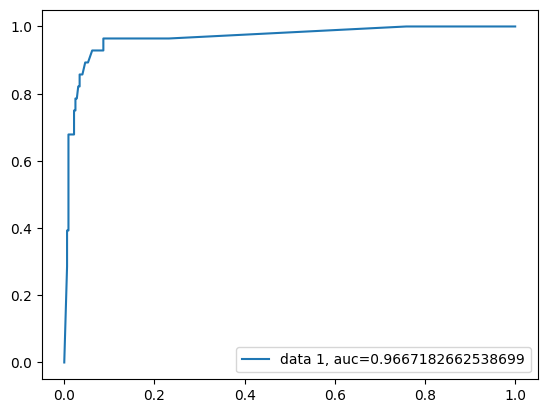

(351, 3)


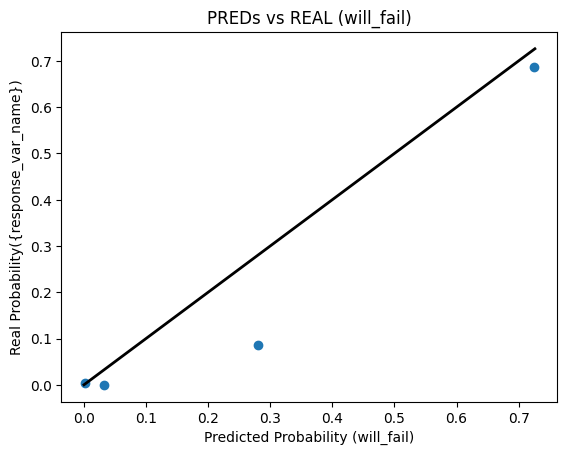

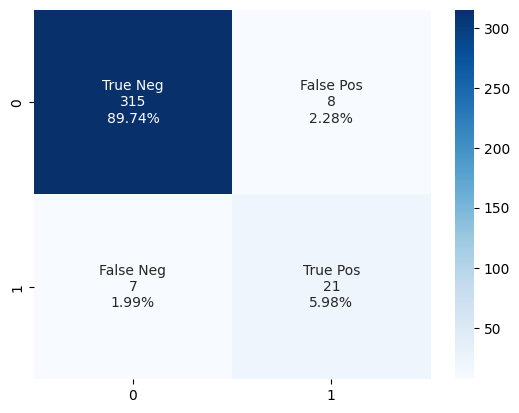

---------- RANDOMFORESTCLASSIFIER --> seed = 150 RESULTS ----------
Worst investment: $28
Ideal investment: $14.0
Model investment: $21.5
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $14.0		 (50.0% of worst investment/no maintainance)
Total savings:		 $6.5		 (46.43% of total opportunity)
Missed savings:		 $7.5		 (53.57% of total opportunity)




-------------------------------------------------- RANDOMFORESTCLASSIFIER --> seed = 1234 --------------------------------------------------
Calibrating model hyperparameters...
(817, 66) (817, 1)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 2/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=nan total time=   0.0s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=nan total time=   0.0s
[CV 1/3] END

/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
12 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/

Calibration done!
Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


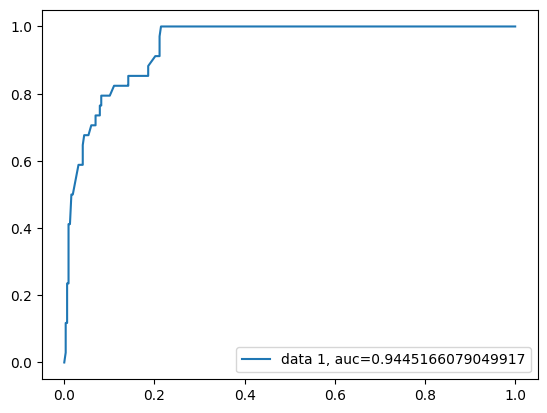

(351, 3)


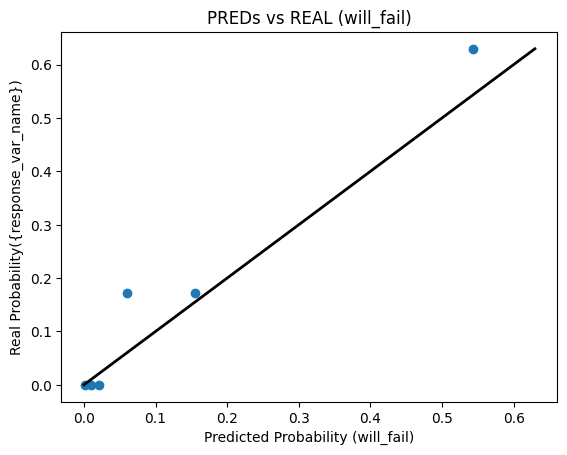

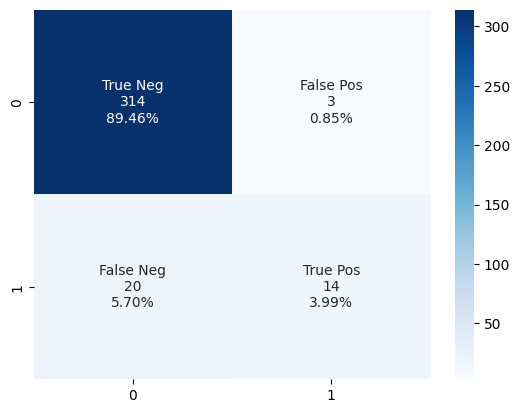

---------- RANDOMFORESTCLASSIFIER --> seed = 1234 RESULTS ----------
Worst investment: $34
Ideal investment: $17.0
Model investment: $28.5
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $17.0		 (50.0% of worst investment/no maintainance)
Total savings:		 $5.5		 (32.35% of total opportunity)
Missed savings:		 $11.5		 (67.65% of total opportunity)




================================================== XGBCLASSIFIER ==================================================
-------------------------------------------------- XGBCLASSIFIER --> seed = 0 --------------------------------------------------
Calibrating model hyperparameters...
(817, 66) (817, 1)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[03:31:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:31:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:31:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:31:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:31:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:31:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "

[CV 1/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=0.971 total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=0.938 total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=0.956 total time=   1.0s


[03:31:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:31:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:31:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 3/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.952 total time=   1.8s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.974 total time=   1.9s
[CV 3/3] END bootstrap=False, max_depth=22, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=114;, score=0.956 total time=   0.9s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.949 total time=   2.0s
[CV 2/3] END bootstrap=False, max_depth=22, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=114;, score=0.938 total time=   1.1s


[03:31:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:31:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:31:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "

[CV 1/3] END bootstrap=False, max_depth=22, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=114;, score=0.971 total time=   1.1s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.974 total time=   1.9s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.949 total time=   2.0s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.952 total time=   1.9s


[03:32:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 1/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.971 total time=   2.8s
[CV 3/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.949 total time=   2.8s
[CV 2/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.945 total time=   2.9s


[03:32:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 3/3] END bootstrap=False, max_depth=38, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=114;, score=0.956 total time=   0.8s
[CV 1/3] END bootstrap=False, max_depth=38, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=114;, score=0.971 total time=   1.0s
[CV 2/3] END bootstrap=False, max_depth=38, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=114;, score=0.938 total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=178;, score=0.971 total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=178;, score=0.956 total time=   1.7s


[03:32:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "

[CV 2/3] END bootstrap=True, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=178;, score=0.938 total time=   1.8s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=114;, score=0.971 total time=   1.0s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=114;, score=0.952 total time=   1.0s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=114;, score=0.949 total time=   1.1s


[03:32:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 2/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.945 total time=   2.7s
[CV 1/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.971 total time=   2.7s
[CV 3/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.949 total time=   2.7s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=242;, score=0.967 total time=   1.6s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=242;, score=0.952 total time=   1.5s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=242;, score=0.949 total time=   1.6s


/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:32:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Calibration done!


/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:32:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:32:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:32:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not u

Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


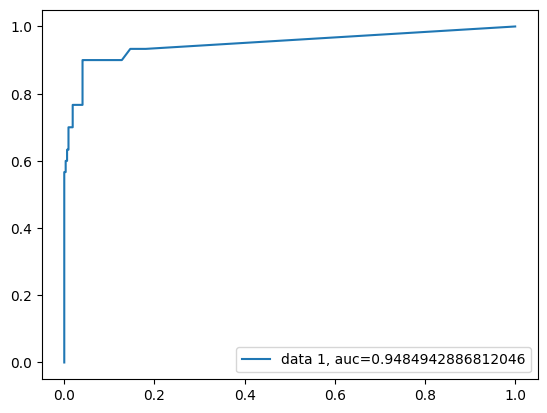

(351, 3)


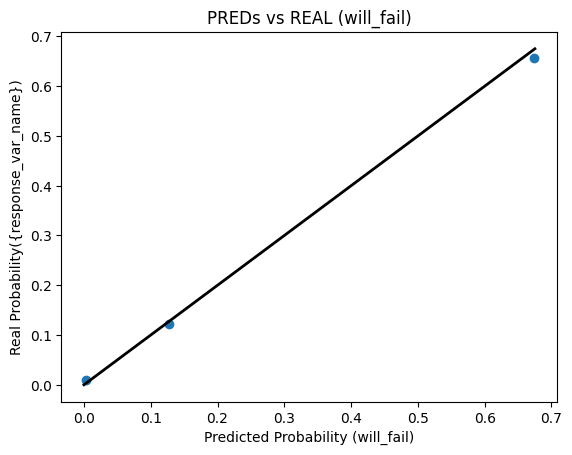

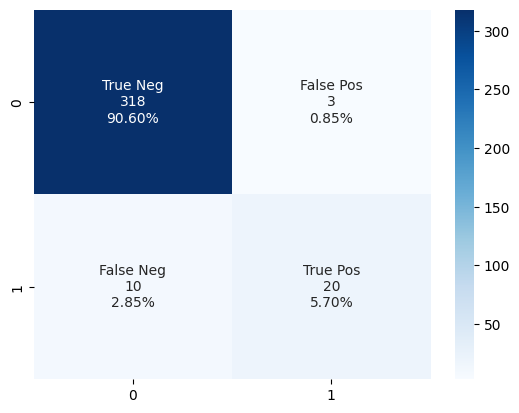

---------- XGBCLASSIFIER --> seed = 0 RESULTS ----------
Worst investment: $30
Ideal investment: $15.0
Model investment: $21.5
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $15.0		 (50.0% of worst investment/no maintainance)
Total savings:		 $8.5		 (56.67% of total opportunity)
Missed savings:		 $6.5		 (43.33% of total opportunity)




-------------------------------------------------- XGBCLASSIFIER --> seed = 50 --------------------------------------------------
Calibrating model hyperparameters...
(817, 66) (817, 1)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[03:32:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "

[CV 1/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=0.945 total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=0.963 total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=0.960 total time=   1.1s


[03:32:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 1/3] END bootstrap=False, max_depth=22, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=114;, score=0.941 total time=   1.0s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.938 total time=   1.9s
[CV 2/3] END bootstrap=False, max_depth=22, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=114;, score=0.963 total time=   1.0s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.960 total time=   2.1s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.960 total time=   2.1s


[03:32:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 3/3] END bootstrap=False, max_depth=22, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=114;, score=0.963 total time=   1.2s


[03:32:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.938 total time=   2.5s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.960 total time=   2.6s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.960 total time=   2.5s


[03:32:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 1/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.949 total time=   3.2s
[CV 2/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.960 total time=   3.2s
[CV 3/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.960 total time=   3.2s


[03:32:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 1/3] END bootstrap=False, max_depth=38, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=114;, score=0.941 total time=   0.7s
[CV 1/3] END bootstrap=True, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=178;, score=0.945 total time=   1.2s
[CV 2/3] END bootstrap=False, max_depth=38, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=114;, score=0.963 total time=   0.8s


[03:32:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 2/3] END bootstrap=True, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=178;, score=0.960 total time=   1.3s
[CV 3/3] END bootstrap=True, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=178;, score=0.963 total time=   1.3s
[CV 3/3] END bootstrap=False, max_depth=38, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=114;, score=0.963 total time=   0.9s


[03:32:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=114;, score=0.930 total time=   0.8s


[03:32:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 2/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=114;, score=0.956 total time=   0.9s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=114;, score=0.960 total time=   0.9s


[03:32:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 1/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.949 total time=   2.3s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=242;, score=0.938 total time=   1.4s
[CV 3/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.960 total time=   2.3s
[CV 2/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.960 total time=   2.4s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=242;, score=0.960 total time=   1.3s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=242;, score=0.956 total time=   1.3s


/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:32:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Calibration done!


/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:32:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:32:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:32:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not u

Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


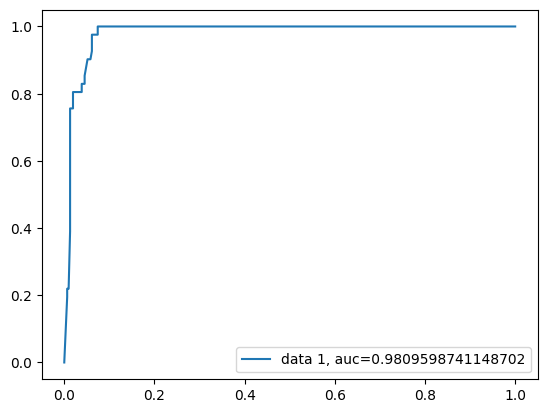

(351, 3)


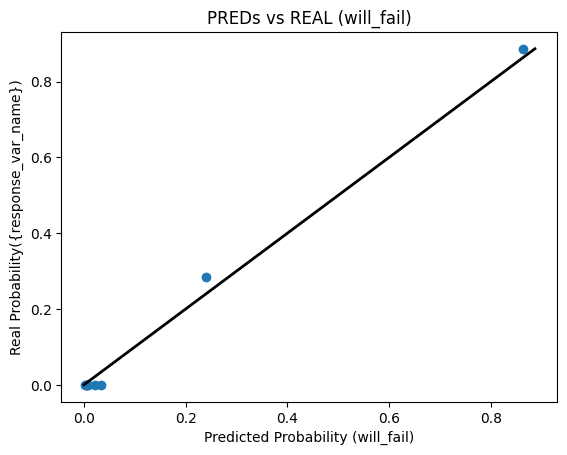

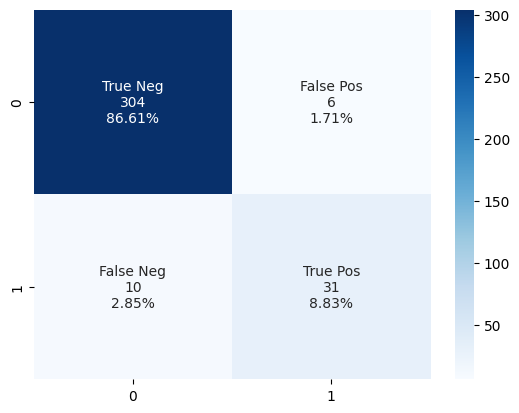

---------- XGBCLASSIFIER --> seed = 50 RESULTS ----------
Worst investment: $41
Ideal investment: $20.5
Model investment: $28.5
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $20.5		 (50.0% of worst investment/no maintainance)
Total savings:		 $12.5		 (60.98% of total opportunity)
Missed savings:		 $8.0		 (39.02% of total opportunity)




-------------------------------------------------- XGBCLASSIFIER --> seed = 100 --------------------------------------------------
Calibrating model hyperparameters...
(817, 66) (817, 1)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[03:32:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "

[CV 3/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=0.938 total time=   1.2s
[CV 1/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=0.963 total time=   1.3s
[CV 2/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=0.963 total time=   1.3s


[03:32:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 3/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.934 total time=   2.2s
[CV 1/3] END bootstrap=False, max_depth=22, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=114;, score=0.963 total time=   1.2s
[CV 3/3] END bootstrap=False, max_depth=22, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=114;, score=0.938 total time=   1.1s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.963 total time=   2.4s


[03:32:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 2/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.967 total time=   2.5s
[CV 2/3] END bootstrap=False, max_depth=22, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=114;, score=0.963 total time=   1.5s


[03:32:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 3/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.934 total time=   2.5s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.963 total time=   2.9s


[03:32:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 2/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.967 total time=   3.1s


[03:32:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 3/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.938 total time=   4.7s
[CV 1/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.963 total time=   4.9s
[CV 2/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.971 total time=   4.9s


[03:32:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 3/3] END bootstrap=True, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=178;, score=0.938 total time=   2.6s
[CV 1/3] END bootstrap=False, max_depth=38, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=114;, score=0.963 total time=   1.1s
[CV 2/3] END bootstrap=False, max_depth=38, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=114;, score=0.963 total time=   1.2s
[CV 3/3] END bootstrap=False, max_depth=38, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=114;, score=0.938 total time=   1.1s


[03:32:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 2/3] END bootstrap=True, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=178;, score=0.963 total time=   3.3s


[03:32:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 1/3] END bootstrap=True, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=178;, score=0.963 total time=   3.7s


[03:32:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 3/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=114;, score=0.934 total time=   1.2s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=114;, score=0.963 total time=   1.9s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=114;, score=0.963 total time=   1.7s


[03:32:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 3/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=242;, score=0.934 total time=   1.8s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=242;, score=0.963 total time=   2.0s
[CV 3/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.938 total time=   3.9s
[CV 2/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.971 total time=   4.1s[CV 2/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=242;, score=0.967 total time=   2.1s

[CV 1/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.963 total time=   4.2s


/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:32:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Calibration done!


/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:32:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:32:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:32:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not u

Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


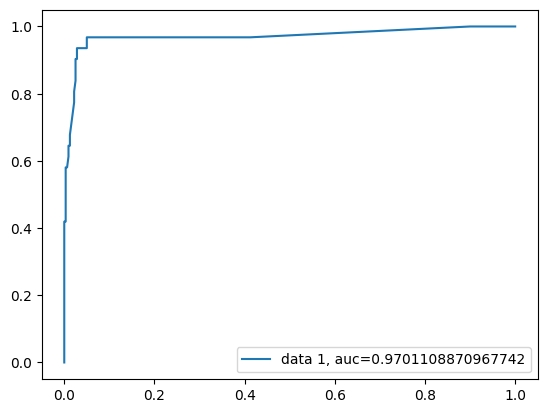

(351, 3)


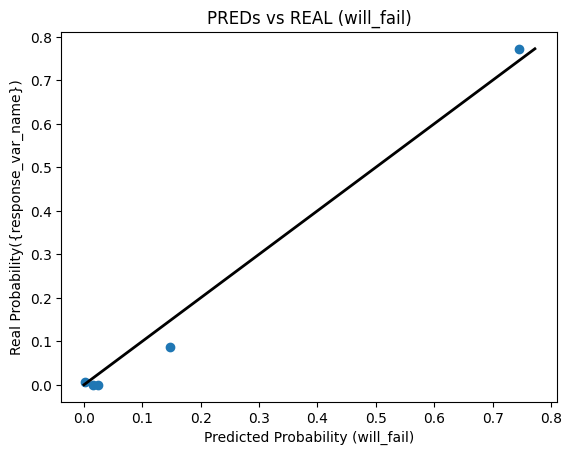

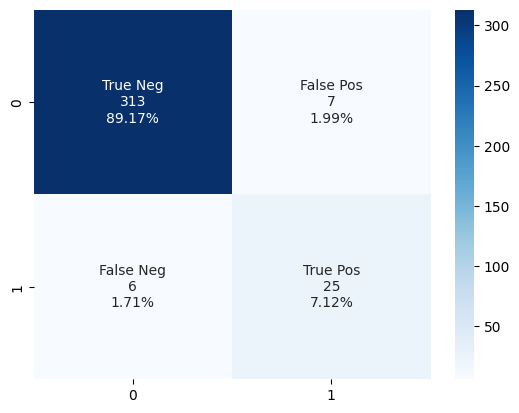

---------- XGBCLASSIFIER --> seed = 100 RESULTS ----------
Worst investment: $31
Ideal investment: $15.5
Model investment: $22.0
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $15.5		 (50.0% of worst investment/no maintainance)
Total savings:		 $9.0		 (58.06% of total opportunity)
Missed savings:		 $6.5		 (41.94% of total opportunity)




-------------------------------------------------- XGBCLASSIFIER --> seed = 150 --------------------------------------------------
Calibrating model hyperparameters...
(817, 66) (817, 1)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[03:32:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "

[CV 2/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=0.938 total time=   1.0s
[CV 3/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=0.963 total time=   1.0s
[CV 1/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=0.960 total time=   1.1s


[03:32:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 2/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.938 total time=   1.7s
[CV 2/3] END bootstrap=False, max_depth=22, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=114;, score=0.938 total time=   0.7s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.971 total time=   1.7s
[CV 1/3] END bootstrap=False, max_depth=22, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=114;, score=0.960 total time=   0.8s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.974 total time=   1.8s


[03:32:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 3/3] END bootstrap=False, max_depth=22, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=114;, score=0.963 total time=   0.8s


[03:32:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 2/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.938 total time=   3.0s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.974 total time=   3.2s


[03:32:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 3/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.971 total time=   3.5s


[03:32:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 2/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.930 total time=   4.1s
[CV 3/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.971 total time=   4.1s
[CV 1/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.960 total time=   4.3s


[03:32:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 1/3] END bootstrap=True, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=178;, score=0.960 total time=   2.0s[CV 1/3] END bootstrap=False, max_depth=38, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=114;, score=0.960 total time=   1.0s

[CV 2/3] END bootstrap=True, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=178;, score=0.938 total time=   1.9s
[CV 2/3] END bootstrap=False, max_depth=38, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=114;, score=0.938 total time=   1.0s


[03:32:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 3/3] END bootstrap=True, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=178;, score=0.963 total time=   2.3s
[CV 3/3] END bootstrap=False, max_depth=38, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=114;, score=0.963 total time=   2.0s


[03:32:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 2/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=114;, score=0.938 total time=   1.3s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=114;, score=0.971 total time=   2.4s


[03:32:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 3/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=114;, score=0.971 total time=   1.7s


[03:32:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 2/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=242;, score=0.938 total time=   1.7s
[CV 2/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.930 total time=   4.2s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=242;, score=0.974 total time=   2.0s
[CV 3/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.971 total time=   4.2s
[CV 1/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.960 total time=   4.3s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=242;, score=0.971 total time=   1.5s


/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:32:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Calibration done!


/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:32:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:32:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:32:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not u

Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


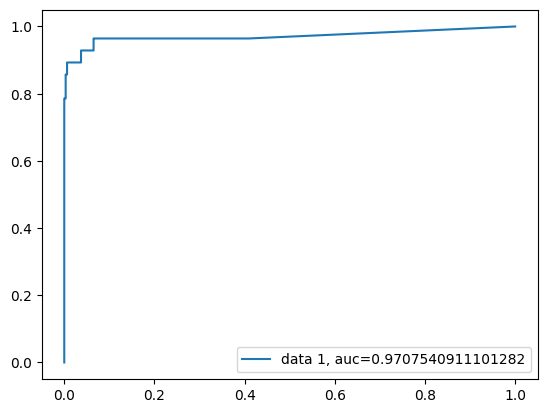

(351, 3)


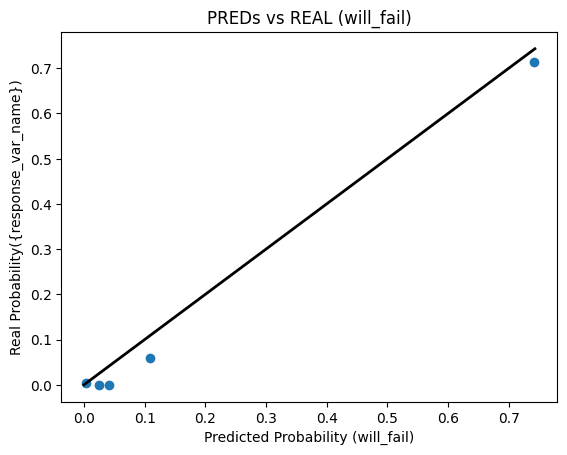

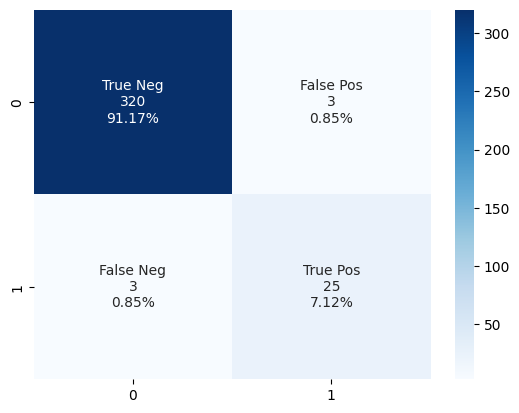

---------- XGBCLASSIFIER --> seed = 150 RESULTS ----------
Worst investment: $28
Ideal investment: $14.0
Model investment: $17.0
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $14.0		 (50.0% of worst investment/no maintainance)
Total savings:		 $11.0		 (78.57% of total opportunity)
Missed savings:		 $3.0		 (21.43% of total opportunity)




-------------------------------------------------- XGBCLASSIFIER --> seed = 1234 --------------------------------------------------
Calibrating model hyperparameters...
(817, 66) (817, 1)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[03:32:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "

[CV 3/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=0.956 total time=   1.1s
[CV 1/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=0.960 total time=   1.2s
[CV 2/3] END bootstrap=True, max_depth=22, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=178;, score=0.956 total time=   1.2s


[03:32:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 3/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.952 total time=   1.8s
[CV 1/3] END bootstrap=False, max_depth=22, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=114;, score=0.960 total time=   0.8s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.960 total time=   1.9s
[CV 3/3] END bootstrap=False, max_depth=22, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=114;, score=0.956 total time=   0.7s
[CV 2/3] END bootstrap=False, max_depth=22, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=114;, score=0.956 total time=   0.9s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.949 total time=   2.0s


[03:32:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "

[CV 3/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.952 total time=   2.1s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.949 total time=   2.2s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=371;, score=0.960 total time=   2.2s


[03:32:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 3/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.956 total time=   2.7s
[CV 1/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.960 total time=   2.9s
[CV 2/3] END bootstrap=True, max_depth=18, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.956 total time=   2.9s


[03:32:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 1/3] END bootstrap=True, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=178;, score=0.960 total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=178;, score=0.956 total time=   1.4s
[CV 1/3] END bootstrap=False, max_depth=38, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=114;, score=0.960 total time=   1.0s
[CV 3/3] END bootstrap=False, max_depth=38, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=114;, score=0.956 total time=   0.9s
[CV 2/3] END bootstrap=False, max_depth=38, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=114;, score=0.956 total time=   1.0s


[03:32:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "

[CV 2/3] END bootstrap=True, max_depth=22, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=178;, score=0.956 total time=   1.6s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=114;, score=0.956 total time=   0.8s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=114;, score=0.960 total time=   0.9s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=114;, score=0.956 total time=   0.9s


[03:32:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[03:32:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[CV 1/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.960 total time=   2.1s
[CV 2/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.956 total time=   2.1s
[CV 1/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=242;, score=0.960 total time=   1.2s
[CV 3/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=242;, score=0.956 total time=   1.1s
[CV 3/3] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=435;, score=0.956 total time=   2.1s
[CV 2/3] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=242;, score=0.952 total time=   1.2s


/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:33:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Calibration done!


/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:33:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:33:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/rafael.naterodasilva/Desktop/MELI/Teste Técnico - DS /meli_py312/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [03:33:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not u

Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


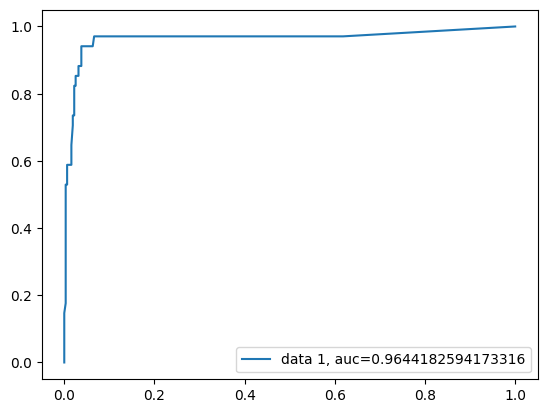

(351, 3)


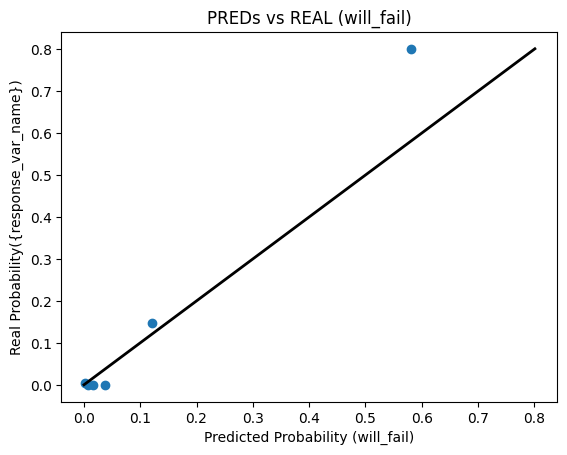

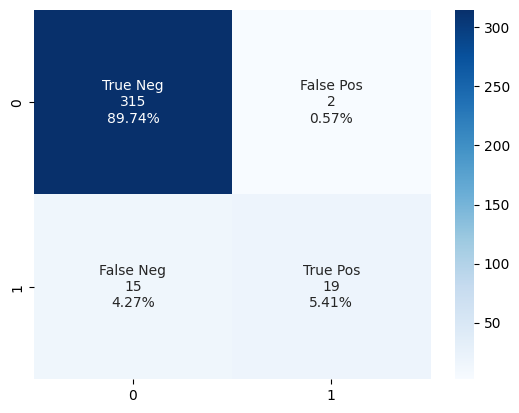

---------- XGBCLASSIFIER --> seed = 1234 RESULTS ----------
Worst investment: $34
Ideal investment: $17.0
Model investment: $25.5
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $17.0		 (50.0% of worst investment/no maintainance)
Total savings:		 $8.5		 (50.0% of total opportunity)
Missed savings:		 $8.5		 (50.0% of total opportunity)






In [40]:
models = ['RandomForestClassifier', 'XGBClassifier']
seeds = list(range(0,200,50))+[1234]

print('- BASE MODELS -'*5)
for selected_model in models:
    print('='*50,selected_model.upper(),'='*50)
    
    for seed in seeds:
        # TRAIN/TEST SPLIT (using different random states)
        X_train, X_test, y_train, y_test, X_train_devices, X_test_devices = rand_sample_devices(df_devices_new, train_split=0.7, seed=seed)
        
        print('-'*50,selected_model.upper(),'--> seed =',seed,'-'*50)
        
        #Train model
        model, X = train_model(X_train, y_train, hyper_tuning=1, calibrate_prob=1, seed=seed, model_selected=selected_model)
        
        #Apply model
        preds, X_test_preds = apply_model(X_test)
        
        #Join Results
        response_var_name = 'will_fail'
        X_preds_vs_real = pd.concat([X_test_devices, X_test_preds[['preds']]], axis=1)
        X_preds_vs_real = pd.concat([X_preds_vs_real, y_test], axis=1)
        X_preds_vs_real['y_preds'] = (X_preds_vs_real['preds']>=0.5).astype(int)

        # Plot ROC Curve and Prob_plot
        X = X_preds_vs_real[['preds']].copy()
        y = X_preds_vs_real[['will_fail']].copy()
        auc_ = roc_plot(X, y)
        brier_ = prob_plot(X, y, response_var_name)
        cf_matrix = confusion_matrix_heatmap(df=X_preds_vs_real, y_pred_col='y_preds', y_col='will_fail')

        print('-'*10,selected_model.upper(),'--> seed =',seed,'RESULTS','-'*10)
        results_summary(df=X_preds_vs_real, real_y_name='will_fail', pred_y_name='y_preds')
        print('\n')
        print('='*140)
        print('\n')

# CHOSEN MODEL (XGBClassifier Base Model)

From the evaluation done in the last 2 cells: 
- testing multiple seeds for XGBClassifier and RandomForestClassifier.
- with and without hyperparameter tuning and calibration.

I observed that the model that generated the biggest (and consistent) cost reduction with the least computational effort was the base model **XGBClassifier** (no calibration and no tuning).

Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)


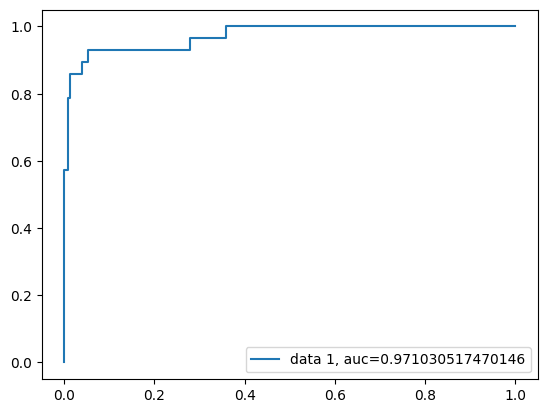

(351, 3)


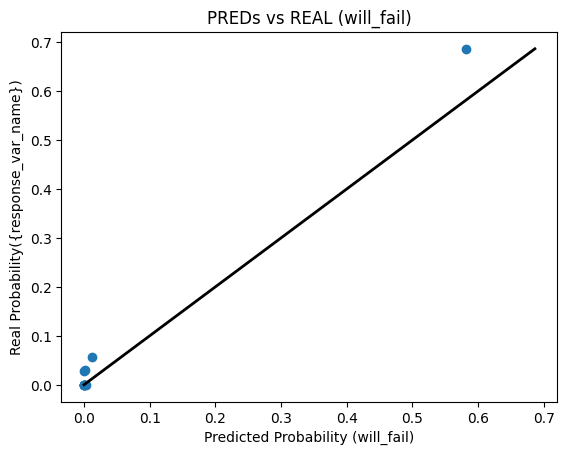

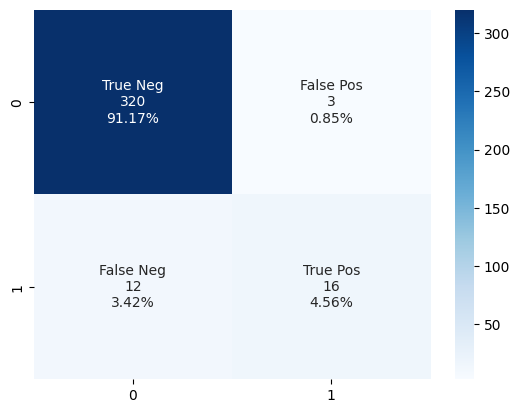

Worst investment: $28
Ideal investment: $14.0
Model investment: $21.5
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $14.0		 (50.0% of worst investment/no maintainance)
Total savings:		 $6.5		 (46.43% of total opportunity)
Missed savings:		 $7.5		 (53.57% of total opportunity)


In [43]:
seed = random.randint(0,100000)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# TRAIN/TEST SPLIT (using different random states)
X_train, X_test, y_train, y_test, X_train_devices, X_test_devices = rand_sample_devices(df_devices_new, train_split=0.7, seed=seed)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# EXECUTE TRAIN MODEL
# Available dfs: X_train, X_test, y_train, y_test, X_train_devices, X_test_devices

model, X = train_model(X_train, y_train, hyper_tuning=0, calibrate_prob=0, seed=seed, model_selected='XGBClassifier')

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# APPLY MODEL TO X_TEST
# Available dfs: X_train, X_test, y_train, y_test, X_train_devices, X_test_devices

preds, X_test_preds = apply_model(X_test)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# PREPARE DATA FOR EVALUATION
response_var_name = 'will_fail'

X_preds_vs_real = pd.concat([X_test_devices, X_test_preds[['preds']]], axis=1)
X_preds_vs_real = pd.concat([X_preds_vs_real, y_test], axis=1)
X_preds_vs_real['y_preds'] = (X_preds_vs_real['preds']>=0.5).astype(int)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# Plot ROC, PROB_PLOT (pred vs. real), and CONFUSION_MATRIX
#X = X_preds_vs_real[['y_preds']].rename(columns={'y_preds':'preds'})
X = X_preds_vs_real[['preds']].copy()
y = X_preds_vs_real[['will_fail']].copy()
response_var_name = 'will_fail'

auc_ = roc_plot(X, y)
brier_ = prob_plot(X, y, response_var_name)
cf_matrix = confusion_matrix_heatmap(df=X_preds_vs_real, y_pred_col='y_preds', y_col='will_fail')

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
#PRINT INVESTMENT RESULTS
total_opportunity, total_monetary_savings, total_pct_savings = results_summary(df=X_preds_vs_real, real_y_name='will_fail', pred_y_name='y_preds')



In [94]:
monetary_savings=[]
pct_savings=[]

train_test_cols = [
    'device', 'num_days', 
    'date_dt_max_day', 'date_dt_max_month', 'date_dt_max_weekday', 
    'device_0_4_S1F0', 'device_0_4_S1F1', 'device_0_4_W1F0', 'device_0_4_W1F1', 'device_0_4_Z1F0', 'device_0_4_Z1F1', 
    'attribute1', 'attribute1_min', 'attribute1_max', 'attribute1_mean', 'attribute1_nunique', #'attribute1_sum', 'attribute1_std', 
    'attribute2', 'attribute2_min', 'attribute2_max', 'attribute2_mean', 'attribute2_nunique', #'attribute2_sum', 'attribute2_std', 
    'attribute3', 'attribute3_min', 'attribute3_max', 'attribute3_mean', 'attribute3_nunique', #'attribute3_sum', 'attribute3_std', 
    'attribute4', 'attribute4_min', 'attribute4_max', 'attribute4_mean', 'attribute4_nunique', #'attribute4_sum', 'attribute4_std', 
    'attribute5', 'attribute5_min', 'attribute5_max', 'attribute5_mean', 'attribute5_nunique', #'attribute5_sum', 'attribute5_std', 
    'attribute6', 'attribute6_min', 'attribute6_max', 'attribute6_mean', 'attribute6_nunique', #'attribute6_sum', 'attribute6_std', 
    'attribute7', 'attribute7_min', 'attribute7_max', 'attribute7_mean', 'attribute7_nunique', #'attribute7_sum', 'attribute7_std', 
    'attribute9', 'attribute9_min', 'attribute9_max', 'attribute9_mean', 'attribute9_nunique', #'attribute9_sum', 'attribute9_std', 
    'will_fail'
]

remove_outliers_from_train = 0

### OUTLIER REMOVAL IMPACT FUNCTION
def outlier_removal(df):
    #print(f'df_size before outlier removal {len(df)}')
    df_no_outliers = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    #print(f'df_size before outlier removal {len(df_no_outliers)}')
    return df_no_outliers

num_iterations = 20

# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 

for i in range(0,num_iterations):
    print()
    seed = random.randint(0,100000)

    print('='*40,'XGBClassifier -> seed =',seed,'='*40)

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # TRAIN/TEST SPLIT (using different random states)
    X_train, X_test, y_train, y_test, X_train_devices, X_test_devices = rand_sample_devices(df_devices_new[train_test_cols], train_split=0.7, seed=seed)

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # Remove Outliers from train data (if wanted)
    if remove_outliers_from_train == 1:
        X_train = outlier_removal(X_train)
        y_train = y_train.loc[X_train.index,:]
        X_train_devices = X_train_devices.loc[X_train.index,:]
    else:
        pass

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # EXECUTE TRAIN MODEL
    # Available dfs: X_train, X_test, y_train, y_test, X_train_devices, X_test_devices

    model, X = train_model(X_train, y_train, hyper_tuning=0, calibrate_prob=0, seed=seed, model_selected='XGBClassifier')

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # APPLY MODEL TO X_TEST
    # Available dfs: X_train, X_test, y_train, y_test, X_train_devices, X_test_devices

    preds, X_test_preds = apply_model(X_test)

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # PREPARE DATA FOR EVALUATION
    response_var_name = 'will_fail'

    X_preds_vs_real = pd.concat([X_test_devices, X_test_preds[['preds']]], axis=1)
    X_preds_vs_real = pd.concat([X_preds_vs_real, y_test], axis=1)
    X_preds_vs_real['y_preds'] = (X_preds_vs_real['preds']>=0.5).astype(int)

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    ## Plot ROC, PROB_PLOT (pred vs. real), and CONFUSION_MATRIX
    ##X = X_preds_vs_real[['y_preds']].rename(columns={'y_preds':'preds'})
    #X = X_preds_vs_real[['preds']].copy()
    #y = X_preds_vs_real[['will_fail']].copy()
    #response_var_name = 'will_fail'
    #auc_ = roc_plot(X, y)
    #brier_ = prob_plot(X, y, response_var_name)
    #cf_matrix = confusion_matrix_heatmap(df=X_preds_vs_real, y_pred_col='y_preds', y_col='will_fail')

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    #PRINT INVESTMENT RESULTS
    total_opportunity, total_monetary_savings, total_pct_savings = results_summary(df=X_preds_vs_real, real_y_name='will_fail', pred_y_name='y_preds')

    monetary_savings.append(total_monetary_savings)
    pct_savings.append(total_pct_savings)


======================================== XGBClassifier -> seed = 10745 ========================================


Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)
Worst investment: $29
Ideal investment: $14.5
Model investment: $19.0
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $14.5		 (50.0% of worst investment/no maintainance)
Total savings:		 $10.0		 (68.97% of total opportunity)
Missed savings:		 $4.5		 (31.03% of total opportunity)

======================================== XGBClassifier -> seed = 3186 ========================================
Applying the trained model on X (X_test)...
Size of X (X_test)...
(351, 66)
Worst investment: $31
Ideal investment: $15.5
Model investment: $19.5
----------------------------------------------------------------------------------------------------
Total Opportunity:	 $15.5		 (50.0% of worst investment/no maintainance)
Total savings:		 $11.5		 (74.19% of total opportunity)
Missed savings:		 $4.0		 (25.81% of total opportunity)

=============================

In [95]:
#print(f'AVG total_opportunity = ${np.mean(total_opportunity)}')
#print(f'AVG total_monetary_savings: {np.mean(total_monetary_savings)}')
print(f'AVG total_pct_savings: {np.mean(total_pct_savings)}')

AVG total_pct_savings: 0.7428571428571429


# CONCLUSION

The model is able to reduce costs by 50%-75%. On average, around 68%.

The two ways it produces those savings are:
- Avoiding maintenance on devices that will (probably) not going to fail.
- Maximizing maintenance on devices that will (probably) going to fail.

So, for every $100 that would be spent on fixing the already failed devices, the model would be able to reduce that spending by around 64%, or $64 by predicting which devices would probably fail.